In [ ]:
#Importing all necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import missingno as msno
from prettytable import PrettyTable
import plotly.express as px
import scipy.stats
from plotly.subplots import make_subplots
import plotly.graph_objects as go
# import plotly.offline as pyo
# pyo.init_notebook_mode()
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pickle
import os
import joblib
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error, median_absolute_error

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
## some utility functions
## defining a function to evaluate given model
def evaluate(train, y_train, test, y_test, model, metric):
    tr, val = train.copy(), test.copy()
    scaler=StandardScaler()
    scaler.fit(tr)
    tr = scaler.transform(tr)
    val = scaler.transform(val)
    #fit model
    model.fit(tr, y_train)
    pred = model.predict(val) #predict
    error = metric(y_test, pred) #measure accuracy
    score_train = model.score(tr, y_train)
    score_test = model.score(val, y_test)

    return error, score_train, score_test

#save dataframe to csv
def save_to_csv(dataframe, file_name):
      path = '/content/drive/MyDrive/project_asteroid/data'
      dataframe.to_csv(os.path.join(path, file_name), index=False)
  
## plotting feature importance
def plot_feature_imp(model, train_data, feature_set):
    """ function to plot feature importance"""
    fig, ax = plt.subplots(figsize=(8,4))
    ax = sns.barplot(x=np.sort(model.feature_importances_)[::-1], y=train_data.columns)
    ax.set(xscale='log')
    ax.set_title(f'Feature Importance - {feature_set}')
    plt.show() 

## Inferences from EDA notebook

- Diameter is right skewed, we have soem outliers which actual events that needs to be considered. Hence we should use a metric that does not penalizes these

- Continuous independent variables are of varying scale and distribution, we would need to apply standarization before modelling

- 54% of features have high VIF score depicting high multicollinearity, which means our features are not orthogonal

- Variables like **'epoch', 'a', 'ad', 'q', 'per', 'moid', orbit classes, neo **with high VIF value indicates **high collinearity** with other variables

- Among continuous features, **albedo, H, data_arc, 'ad', 'a', 'q', 'e' seems useful** for the diameter prediction based on pdf and cdf study with diameter size-class

- Continuous features **data_arc** display **strong correlation with diameter** as stated by pearson correlation coefficient value

- Categorical variable **pha, neo, class** to have **strong correlation with diameter** as depicted by Cramer's V Score

- Information gain based feature importance revealed most **important features to be - 'H', data_arc, moid, 'q', 'a', albedo**

- **'w', 'ma', 'om' are not important features**



In [ ]:
df = pd.read_csv('/content/drive/MyDrive/project_asteroid/asteroids_final.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (1,7,14,15) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# Feature Engineering

### Feature Selection based on EDA studies

In [ ]:
# original dataset shape
df.shape

(139708, 37)

In [ ]:
# creating a new dataframe from master
dfe = df.copy()

- drop features - as inferred from the Missing Value review(>80% data insuffieciency), and other reasons like data irrelevance
- drop 'w', 'ma', 'om' as understood from EDA feature correlation and feature importance studies
- Top most important features - albedo, H, data_arc, 'ad', 'a', 'q', 'e', moid. Orbit class, neo, pha too have strong corrlation with diameter

In [ ]:
# dataframe dfe is a fresh copy from master df, 
# removing features owing to feature irrelevance and missing value analysis (missing>80% data)
dfe.drop(['full_name','name', 'extent', 'rot_per', 'G', 'GM', 'BV', 'UB', 'IR', 'spec_B', 'spec_T',
       'H_sigma', 'diameter_sigma', 'per_y'], axis=1, inplace=True)

In [ ]:
# dropping features as inferred as irrelevant from EDA
dfe.drop([ 'w', 'ma', 'om'], axis=1, inplace=True)

Below is our to_drop list for our dataset

In [ ]:
to_drop_columns = ['full_name','name', 'extent', 'rot_per', 'G', 'GM', 'BV', 'UB', 'IR', 'spec_B', 'spec_T',
       'H_sigma', 'diameter_sigma', 'per_y', 'w', 'ma', 'om']

In [ ]:
# columns in the dataset
dfe.columns

Index(['neo', 'pha', 'H', 'diameter', 'albedo', 'epoch', 'e', 'a', 'q', 'i',
       'ad', 'n', 'tp', 'per', 'moid', 'moid_jup', 'class', 'data_arc',
       'condition_code', 'rms'],
      dtype='object')

In [ ]:
# checking shape of dataset dfe
dfe.shape

(139708, 20)

### Train Test Split

In [ ]:
# defining X, y
y = dfe.diameter
X = dfe.drop('diameter', axis=1)

To do a stratified splitting for the continuous target 'diameter', i am making use of verstack package tool:
- **verstack.stratified_continuous_split.scsplit**
- Reference - https://pypi.org/project/verstack/

In [ ]:
! pip install verstack

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.6 MB 5.1 MB/s 
     |████████████████████████████████| 23.2 MB 86.1 MB/s 
     |████████████████████████████████| 2.0 MB 39.7 MB/s 
     |████████████████████████████████| 308 kB 46.2 MB/s 
     |████████████████████████████████| 23.9 MB 1.2 MB/s 
     |████████████████████████████████| 227 kB 50.7 MB/s 
     |████████████████████████████████| 155 kB 52.6 MB/s 
     |████████████████████████████████| 665.5 MB 18 kB/s 
     |████████████████████████████████| 1.3 MB 38.9 MB/s 
     |████████████████████████████████| 86 kB 5.7 MB/s 
     |████████████████████████████████| 209 kB 46.4 MB/s 
     |████████████████████████████████| 81 kB 9.8 MB/s 
     |████████████████████████████████| 463 kB 55.5 MB/s 
     |████████████████████████████████| 78 kB 7.4 MB/s 
     |████████████████████████████████| 112 kB 68.5 MB/s 
     |███████████████████████████████

In [ ]:
#!pip install protobuf==3.20.*

In [ ]:
import verstack
verstack.__version__

'3.2.3'

In [ ]:
from verstack.stratified_continuous_split import scsplit
X_train, X_test, y_train, y_test = scsplit(X, y, stratify=y, random_state=0) #test_size default=0.3

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((97795, 19), (41913, 19), (97795,), (41913,))

In [ ]:
type(X_train), type(X_test), type(y_train), type(y_test)

(pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame,
 pandas.core.series.Series,
 pandas.core.series.Series)

In [ ]:
#save files
save_to_csv(X_train, 'X_train')
save_to_csv(X_test, 'X_test')
save_to_csv(y_train, 'y_train')
save_to_csv(y_test, 'y_test')

In [ ]:
y_train = pd.read_csv('/content/drive/MyDrive/project_asteroid/data/y_train', squeeze=True)
y_test = pd.read_csv('/content/drive/MyDrive/project_asteroid/data/y_test', squeeze=True)

In [ ]:
y_train.shape, y_test.shape

((97795,), (41913,))

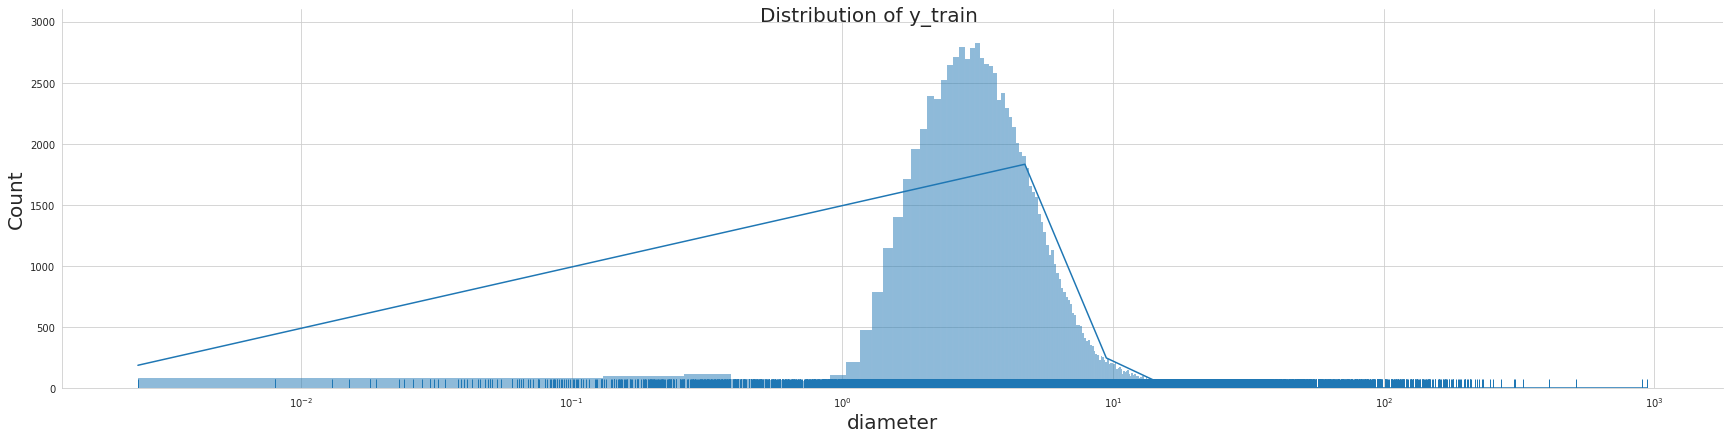

In [ ]:
#plotting y_train distribution
sns.set_style("whitegrid")
g = sns.displot(x=y_train, kde=True, rug=True, height=6, aspect=4)
g.set(xscale='log')
g.set_xlabels(fontsize=20)
g.set_ylabels(fontsize=20)
g.fig.suptitle("Distribution of y_train", fontsize=20)
plt.show()


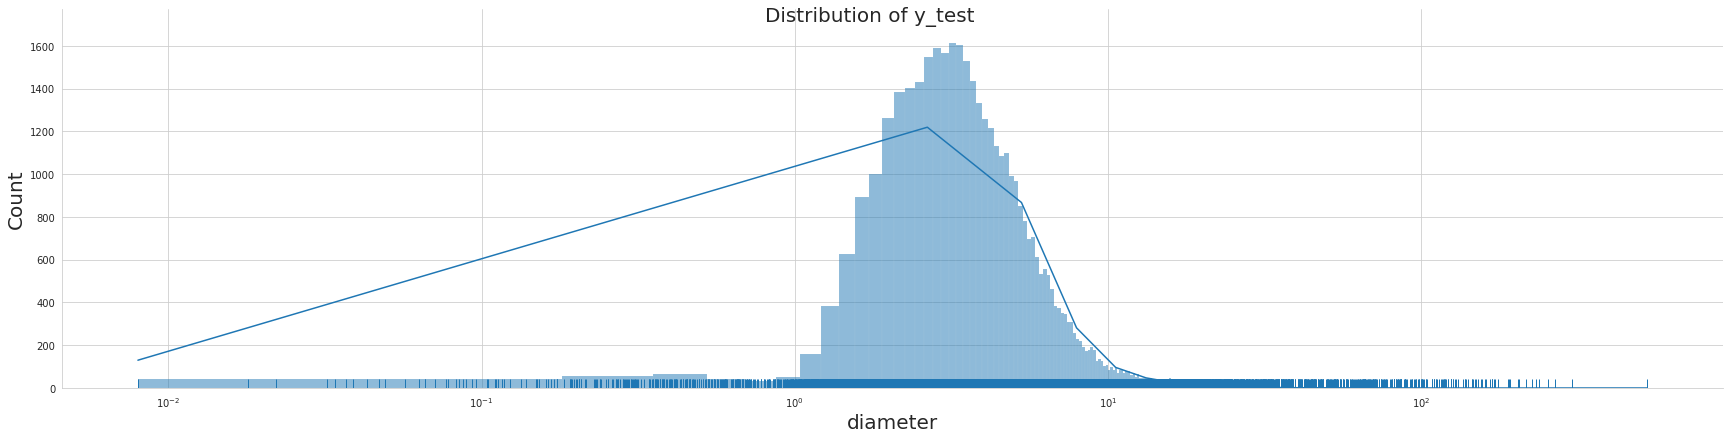

In [ ]:
# plotting y_test distribution
sns.set_style("whitegrid")
g = sns.displot(x=y_test, kde=True, rug=True, height=6, aspect=4)
g.set(xscale='log')
g.set_xlabels(fontsize=20)
g.set_ylabels(fontsize=20)
g.fig.suptitle("Distribution of y_test", fontsize=20)
plt.show()


Observations:
- distribution of y_train and y_test looks similar. 

## Categorical Variables Encoding - one hot encoding

We have three categorical variables:
  - pha: 2 categories (Y/N)
  - neo: 2 categories (Y/N)
  - class: 11 categories of orbit classes

All three categories are nominal, so we will go with one hot encoding

In [ ]:
# improting library
from sklearn.preprocessing import OneHotEncoder

In [ ]:
X_train.dtypes

neo                object
pha                object
H                 float64
albedo            float64
epoch             float64
e                 float64
a                 float64
q                 float64
i                 float64
ad                float64
n                 float64
tp                float64
per               float64
moid              float64
moid_jup          float64
class              object
data_arc          float64
condition_code      int64
rms               float64
dtype: object

In [ ]:
# getting hold of the categorical columns
cat_cols = X_train.dtypes[X_train.dtypes=='object'].index
num_cols = X_train.dtypes[(X_train.dtypes=='float64') | (X_train.dtypes=='int64') ].index

In [ ]:
X_train[cat_cols].head()

,neo,pha,class
51219,N,N,MBA
108225,N,N,MBA
99696,N,N,MBA
27539,N,N,MBA
47816,N,N,MBA


In [ ]:
# applying one hot encoding
ohe = OneHotEncoder(drop='first')
ohe.fit(X_train[cat_cols])
X_train_cat_cols = ohe.transform(X_train[cat_cols]).toarray()
X_test_cat_cols = ohe.transform(X_test[cat_cols]).toarray()

In [ ]:
ohe.get_feature_names_out()

array(['neo_Y', 'pha_Y', 'class_APO', 'class_AST', 'class_ATE',
       'class_CEN', 'class_IMB', 'class_MBA', 'class_MCA', 'class_OMB',
       'class_TJN', 'class_TNO'], dtype=object)

In [ ]:

# with open("encoder", "wb") as f: 
#     pickle.dump(one_hot, f)

We need to concatenate encoded Categorical columns with the numerical set

In [ ]:
X_train_encoded = np.hstack((X_train[num_cols].values, X_train_cat_cols))
X_test_encoded = np.hstack((X_test[num_cols].values, X_test_cat_cols))

In [ ]:
X_train_encoded.shape, X_test_encoded.shape

((97795, 28), (41913, 28))

In [ ]:
# creating dataframes of these outputs
ncols = list(X_train[num_cols].columns)
ccols = list(ohe.get_feature_names_out())
ncols.extend(ccols)
print(ncols)

['H', 'albedo', 'epoch', 'e', 'a', 'q', 'i', 'ad', 'n', 'tp', 'per', 'moid', 'moid_jup', 'data_arc', 'condition_code', 'rms', 'neo_Y', 'pha_Y', 'class_APO', 'class_AST', 'class_ATE', 'class_CEN', 'class_IMB', 'class_MBA', 'class_MCA', 'class_OMB', 'class_TJN', 'class_TNO']


In [ ]:
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=ncols)
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=ncols)

In [ ]:
X_train_encoded_df.head()

,H,albedo,epoch,e,a,q,i,ad,n,tp,...,class_APO,class_AST,class_ATE,class_CEN,class_IMB,class_MBA,class_MCA,class_OMB,class_TJN,class_TNO
0,14.22,0.066,2459800.5,0.0710,3.174,2.948,8.62,3.40,0.1743,2460678.06,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,16.40,0.115,2459800.5,0.1600,2.939,2.468,15.92,3.41,0.1957,2459055.14,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,16.56,0.094,2459800.5,0.0716,2.451,2.275,11.20,2.63,0.2569,2459345.55,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,15.21,0.243,2459800.5,0.0630,2.703,2.533,6.69,2.87,0.2218,2459025.12,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,14.35,0.063,2459800.5,0.1566,2.789,2.352,8.83,3.23,0.2117,2459793.17,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


### Correlation study with encoded independent features
Now that we have have X_train scaled and categoricaly encoded, lets have a look at the correlation between these transformed independent features

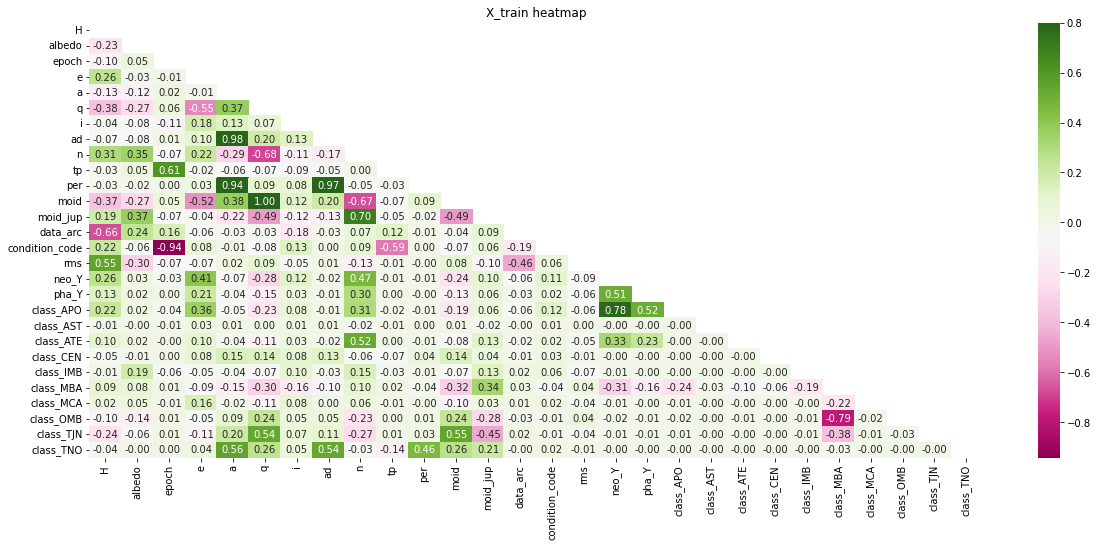

In [ ]:
#plotting heatmap for data correlation
corr_matrix =  X_train_encoded_df.corr()
plt.figure(figsize=(20, 8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, vmax=0.8, annot=True, mask=mask, fmt='.2f', cmap="PiYG")
plt.title("X_train heatmap")
plt.show()

Observations:

- positive correlations:
  - class_TNO display strong positive correlation with 'a', 'ad', 'per'
  - class_TJN display positive correlation with 'q' and moid
  - class_ATE display positive correlation with 'n'
  - class_APO display high correlation with neo_y, and also with pha_y
  - pha_y display high correlation neo_y
  - neo_y display positive corelation with 'e' and 'n'
  - 'a' and 'ad' display high positive correlation
  - 'q' and 'moid' display high positive correlation
  - 'ad' and 'per' display high positive correlation
  - 'n' and 'moid_jupiter' display strong positive correlation 
  - epoch and 'tp' display strong positive correlation
  - 'H' and rms

- High/strong negative correlations observed between:
  - class_TJN and moid_jup
  - class_OMB and class_MBA
  - epoch and condition_code
  - 'tp' and condition_code
  - 'n' and moid
  - moid and moid_jupiter
  - 'e' and 'q'
  - 'H' and 'data_arc'
  - 'q' and 'n'
  - data_arc and rms
  - 'H' and data_arc 


## Missing value Imputation

In [ ]:
X_train_encoded_df.isnull().sum()[X_train_encoded_df.isnull().sum().values>0]

H           771
albedo      754
data_arc     16
dtype: int64

In [ ]:
X_train_encoded_df.isnull().sum()[X_train_encoded_df.isnull().sum().values>0]

H           771
albedo      754
data_arc     16
dtype: int64

### Discussion on coming up with a strategy to impute missing values in  albedo, H, data-arc

#### 1. '**albedo**' - from our EDA, we know overall we have 0.8153% of missing data for the feature

In [ ]:
#let's look at X_train albedo statistics
print(f"'albedo' mean: {round(X_train_encoded_df.albedo.mean(), 2)}")
print(f"'albedo' median: {X_train_encoded_df.albedo.median()}")
albedo_stats_before_imputation = X_train_encoded_df[['albedo']].describe()

'albedo' mean: 0.13
'albedo' median: 0.078



- Domain-specific information:

  - Astronomical albedos are usually given by the IRAS minor planet survey[1] or the MSX minor planet survey[2] (available at the PDS).    These are geometric albedos. If there is no IRAS/MSX data a **rough average of 0.1** can be used. (Source: Source: https://en.wikipedia.org/wiki/Standard_asteroid_physical_characteristics#Albedo)

  - Only a coarse estimation of size can be found from the object's magnitude because an assumption must be made for its albedo which is also not usually known for certain. The NASA near-Earth object program uses an **assumed albedo of 0.14** for this purpose.(Source: https://en.wikipedia.org/wiki/Potentially_hazardous_object#Size)
  - [commonly assumed albedo range for asteroid is between 0.05 - 0.25](http://www.physics.sfasu.edu/astro/asteroids/sizemagnitude.html)
  - Asteroids mainly fall into three categories - 
      - C-type: accounts for 75% of known asteroids, (albedo: 0.03-0.09)
      - S-type(): accounts for 17%
of known asteroids, (albedo: 0.10-0.22)
      - M-type: rest of the asteroids, (albedo: 0.10-0.18)
      https://nssdc.gsfc.nasa.gov/planetary/text/asteroids.txt
  -  Where an asteroid was not included in any of these satellites, the
diameter was estimated from the asteroid’s absolute magnitude H
using 𝐷𝑖𝑎𝑚𝑒𝑡𝑒𝑟 = 10(3.1295−0.5 log10 (𝑎)−0.2𝐻) **with an assumed albedo of a=0.1652** – (Bowell et al. 1989) at p. 551
    - https://arxiv.org/pdf/2010.06086.pdf
    - (Bowell et al. 1989) at p. 551



- Dataset Statistics info- 'albedo' feature mean and median value
    ```
    'albedo' mean: 0.13
    'albedo' median: 0.078
    ```

** caveat: [an error in the assumed albedo can result in a significantly erroneous diameter](https://cneos.jpl.nasa.gov/tools/ast_size_est.html)


---
---
**Imputation strategy**: albedo mean
- statistic mean 0.13 seems to closer domain value 0.14 used by NASA for NEO program. Also we have another domain speicfic mention of asumed value to be 0.16
- statistic median 0.078 goes well with C, S, M type based classes proportion and albedo range
- Based on above facts, seems reasonable to go with mean value of 0.13

#### 2. '**H**' absolute magnitude -  from our EDA, we know overall we have 0.7974% of missing data for the feature

In [ ]:
# total values missing
print(f"Total values missing for 'H': {X_train_encoded_df.H.isnull().sum()}")

#let's look at data statistic
print(f"'H' mean: {round(X_train_encoded_df.H.mean(), 2)}")
print(f"'H' median: {X_train_encoded_df.H.median()}")
H_stats_before_imputation = X_train_encoded_df[['H']].describe()

Total values missing for 'H': 771
'H' mean: 15.35
'H' median: 15.44


- Domain-specific information:

  - Most asteroids have irregular shapes (that is, very few are close to being spherical). However, the size (diameter of an equivalent sphere) of an asteroid can be estimated from its absolute magnitude H and an assumed geometric albedo
  - CNEOS, NASA- Asteroid Size Estimator - https://cneos.jpl.nasa.gov/tools/ast_size_est.html
     - https://www.boulder.swri.edu/clark/jssrpb04.pdf

- Data Statistics based info- 'H' feature mean and median value
    ```
    'H' mean: 15.35
    'H' median: 15.44
    ```

---
---
**Imputation strategy**: 
- Since 'diameter' is the target variable, we cannot apply the domain info of computing 'H' given diameter and albedo
- We had the observed this in CDF plots:
  - 80% of s1 is approx. <=22 absolute magnitude
  - 80% of s2 is approx. <=17 absolute magnitude
  - 80% of s3 is approx. <=14 absolute magnitude
  - 80% of s4 is approx. <=8 absolute magnitude
- mean and median values are closer
- We can try imputing with mean value and see how it works out

#### 3. **data_arc**	from our EDA, we know overall we have 0.0179% of missing data for the feature

data-arc span is number of days spanned by the data-arc

In [ ]:
print(f"data-arc span mean: {round(X_train.data_arc.mean(),2)} days")
print(f"data-arc span median: {round(X_train.data_arc.median(),2)} days")
print(f"data-arc span mean(yr): {round(X_train.data_arc.mean()/365,2)} years")
print(f"data-arc span median(yr): {round(X_train.data_arc.median()/365,2)} years")

data-arc span mean: 10152.49 days
data-arc span median: 8549.0 days
data-arc span mean(yr): 27.82 years
data-arc span median(yr): 23.42 years


In [ ]:
print(f"data_arc mean for near earth objects(neo): {X_train[X_train.neo=='Y'].data_arc.mean()}")
print(f"data_arc median for near earth objects(neo): {X_train[X_train.neo=='Y'].data_arc.median()}")
print(f"data_arc min for near earth objects(neo): {X_train[X_train.neo=='Y'].data_arc.min()}")
print(f"data_arc max for near earth objects(neo): {X_train[X_train.neo=='Y'].data_arc.max()}")

data_arc mean for near earth objects(neo): 6566.335585585585
data_arc median for near earth objects(neo): 5164.5
data_arc min for near earth objects(neo): 1.0
data_arc max for near earth objects(neo): 46582.0


In [ ]:
print(f"data_arc mean for not-neo: {X_train[X_train.neo=='N'].data_arc.mean()}")
print(f"data_arc median for not-neo: {X_train[X_train.neo=='N'].data_arc.median()}")
print(f"data_arc min for not-neo: {X_train[X_train.neo=='N'].data_arc.min()}")
print(f"data_arc max for not-neo: {X_train[X_train.neo=='N'].data_arc.max()}")

data_arc mean for not-neo: 10185.351993477207
data_arc median for not-neo: 8556.0
data_arc min for not-neo: 1.0
data_arc max for not-neo: 79466.0


Exploring the data-arc domain information, could not get enough evidence if we can consider the mean/median as nominal value to substitute missing values. 

**Imputation Strategy:** 
- Mean and median is not close when looking at whole train data
- Mean and median are close for only neo data
- While these value are again apart for non-neo data, which is expected as the variance is larger in this set
- Median seems more reasonable here, lets try with median

### Imputation Implementation :
- **Mean Imputation** for albedo and H
- **Median Imputation** for data-arc

note - try linear regression instead of KNN

Try Simple Imputer on all three and check accuracy 
try linear regression base imputing and check accuracy

In [ ]:
## checking albedo stats
albedo_before_imp = X_train_encoded_df[['albedo']].describe()
H_before_imp = X_train_encoded_df[['H']].describe()

In [ ]:
X_train_imp = X_train_encoded_df.copy()
X_test_imp  = X_test_encoded_df.copy()

In [ ]:
# appling mean imputation
# Importing library
from sklearn.impute import SimpleImputer
mean_imp = SimpleImputer(strategy ='mean')
mean_imp.fit(X_train_imp.loc[:, ['albedo', 'H']])
X_train_imp.loc[:, ['albedo', 'H']] = mean_imp.transform(X_train_imp.loc[:, ['albedo', 'H']])
X_test_imp.loc[:, ['albedo', 'H']] = mean_imp.transform(X_test_imp.loc[:, ['albedo', 'H']])

In [ ]:
## looking at the descriptive stats of albedo and H
albedo_after_imp = X_train_imp[['albedo']].describe()
H_after_imp = X_train_imp[['H']].describe()
pd.DataFrame({'albedo_before': albedo_before_imp.albedo, 'albedo_after': albedo_after_imp.albedo, 'H_before': H_before_imp.H, 'H_after': H_after_imp.H}, index=albedo_after_imp.index)

,albedo_before,albedo_after,H_before,H_after
count,97041.000000,97795.000000,97024.000000,97795.000000
mean,0.129928,0.129928,15.352153,15.352153
std,0.110231,0.109805,1.419130,1.413525
min,0.001000,0.001000,3.330000,3.330000
25%,0.053000,0.053000,14.620000,14.630000
50%,0.078000,0.079000,15.440000,15.430000
75%,0.188000,0.187000,16.230000,16.220000
max,1.000000,1.000000,29.900000,29.900000


Obervation:
- the descriptive stats before and after imputation looks similar.

In [ ]:
## checking the null values in the imputed train df
X_train_imp.isnull().sum()[X_train_imp.isnull().sum() > 0]

data_arc    16
dtype: int64

We see that we have now only data_arc feature with missing values, we will impute it with median startegy

In [ ]:
dataarc_before_imp = X_train_imp[['data_arc']].describe()

In [ ]:
#creating median imputer object and fitting and transforming data

median_imp = SimpleImputer(strategy ='median')
median_imp.fit(X_train_imp)
X_train_imp = median_imp.transform(X_train_imp)
X_test_imp = median_imp.transform(X_test_imp)

In [ ]:
# Converting th eimputed numpy arrays to dataframe
X_train_imp_df= pd.DataFrame(X_train_imp, columns=X_train_encoded_df.columns)
X_test_imp_df = pd.DataFrame(X_test_imp, columns=X_train_encoded_df.columns)

In [ ]:
# checking "data_arc" statistics before and after imputation

dataarc_after_imp = X_train_imp_df[['data_arc']].describe()
pd.DataFrame({'data_arc_before': dataarc_before_imp.data_arc, 'data_arc_after': dataarc_after_imp.data_arc}, index=dataarc_after_imp.index)

,data_arc_before,data_arc_after
count,97779.000000,97795.000000
mean,10152.485155,10152.222813
std,5940.434827,5939.984257
min,1.000000,1.000000
25%,7298.000000,7298.000000
50%,8549.000000,8549.000000
75%,10723.000000,10722.500000
max,79466.000000,79466.000000


Observations:
- data_arc stats before and after imputation looks closer

#### Evaluating the imputed data by fitting a linear regression

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

model = LinearRegression()
metric = mean_absolute_error
mae_imp, score_train_imp, score_test_imp = evaluate(X_train_imp_df, y_train, X_test_imp_df, y_test, model, metric)

In [ ]:
print(f"MAE - imputed data:{mae_imp}")
print(f"Train score - imputed data: {score_train_imp}")
print(f"Test score - imputed data: {score_test_imp}")

MAE - imputed data:2.5190036016420927
Train score - imputed data: 0.5170226467358576
Test score - imputed data: 0.45198612150282236


### Let's try missing Value Imputation using **IterativeImputer**

```Iterative imputation refers to a process where each feature is modeled as a function of the other features, e.g. a regression problem where missing values are predicted. Each feature is imputed sequentially, one after the other, allowing prior imputed values to be used as part of a model in predicting subsequent features. Courtesy: https://machinelearningmastery.com/ ```



In [ ]:
# making a copy of the dataframe and proceed with imputation on the copied version
X_train_iter_imp = X_train_encoded_df.copy()
X_test_iter_imp = X_test_encoded_df.copy()

In [ ]:
# Note This estimator is still experimental for now: the predictions and the API might change without any deprecation cycle. 
# To use it, you need to explicitly import enable_iterative_imputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

iter_imp = IterativeImputer(random_state=0)
iter_imp.fit(X_train_iter_imp)
X_train_iter_imp = iter_imp.transform(X_train_iter_imp)
X_test_iterr_imp = iter_imp.transform(X_test_iter_imp)

In [ ]:
# Converting th eimputed numpy arrays to dataframe
X_train_iter_imp= pd.DataFrame(X_train_iter_imp, columns=X_train_encoded_df.columns)
X_test_iter_imp = pd.DataFrame(X_test_iter_imp, columns=X_train_encoded_df.columns)

In [ ]:
pd.DataFrame({'albedo_before_imputation': albedo_before_imp.albedo, 'albedo_after_mean_imputation': albedo_after_imp.albedo, 'albedo_iter_imp': X_train_iter_imp.albedo.describe()}, index=albedo_after_imp.index)

,albedo_before_imputation,albedo_after_mean_imputation,albedo_iter_imp
count,97041.000000,97795.000000,97795.000000
mean,0.129928,0.129928,0.129439
std,0.110231,0.109805,0.110067
min,0.001000,0.001000,-0.310484
25%,0.053000,0.053000,0.053000
50%,0.078000,0.079000,0.078000
75%,0.188000,0.187000,0.187000
max,1.000000,1.000000,1.000000


In [ ]:
pd.DataFrame({'H_before_imputation': H_before_imp.H, 'H_after_mean_imputaton': H_after_imp.H, 'H_after_iter_imputation':X_train_iter_imp.H.describe()}, index=albedo_after_imp.index)

,H_before_imputation,H_after_mean_imputaton,H_after_iter_imputation
count,97024.000000,97795.000000,97795.000000
mean,15.352153,15.352153,15.381626
std,1.419130,1.413525,1.460900
min,3.330000,3.330000,3.330000
25%,14.620000,14.630000,14.630000
50%,15.440000,15.430000,15.460000
75%,16.230000,16.220000,16.250000
max,29.900000,29.900000,29.900000


In [ ]:
pd.DataFrame({'dataarc_before_imputation': dataarc_before_imp.data_arc, 'dataarc_after_mean_imputation': dataarc_after_imp.data_arc, 'dataarc_after_iter_imputation':X_train_iter_imp.data_arc.describe()}, index=dataarc_after_imp.index)

,dataarc_before_imputation,dataarc_after_mean_imputation,dataarc_after_iter_imputation
count,97779.000000,97795.000000,97795.000000
mean,10152.485155,10152.222813,10150.455118
std,5940.434827,5939.984257,5942.673781
min,1.000000,1.000000,-15402.191152
25%,7298.000000,7298.000000,7297.000000
50%,8549.000000,8549.000000,8549.000000
75%,10723.000000,10722.500000,10723.000000
max,79466.000000,79466.000000,79466.000000


Observation:
- We observe that using Iterative Imputer, we ended up with some negative values for albedo and data_arc, which is not right, as we know from domain info that albedo lies between 0 and 1 and data_arc is the span - number of days which cannot be negative. So ruling out this method

### Lets try **KNN Imputer** as well

In [ ]:
# making a copy of the dataframe and proceed with imputation on the copied version
X_train_knn_imp = X_train_encoded_df.copy()
X_test_knn_imp = X_test_encoded_df.copy()

In [ ]:
from sklearn.impute import KNNImputer

knn_imp = KNNImputer()
knn_imp.fit(X_train_knn_imp)
X_train_knn_imp = knn_imp.transform(X_train_knn_imp)
X_test_knn_imp = knn_imp.transform(X_test_knn_imp)

##### validate the goodness of the imputation technique?
-metric - mse?
- plot distribution of errors

In [ ]:
# Converting th eimputed numpy arrays to dataframe
X_train_knn_imp= pd.DataFrame(X_train_knn_imp, columns=X_train_encoded_df.columns)
X_test_knn_imp = pd.DataFrame(X_test_knn_imp, columns=X_train_encoded_df.columns)

In [ ]:
# compare albedo statistics
pd.DataFrame({'albedo_before_imputation': albedo_before_imp.albedo, 'albedo_after_mean_imputation': albedo_after_imp.albedo, 'albedo_after_iter_imputation': X_train_iter_imp.albedo.describe(), 'albedo_after_knn_imputation': X_train_knn_imp.albedo.describe()}, index=albedo_after_imp.index)

,albedo_before_imputation,albedo_after_mean_imputation,albedo_after_iter_imputation,albedo_after_knn_imputation
count,97041.000000,97795.000000,97795.000000,97795.000000
mean,0.129928,0.129928,0.129439,0.129567
std,0.110231,0.109805,0.110067,0.109981
min,0.001000,0.001000,-0.310484,0.001000
25%,0.053000,0.053000,0.053000,0.053000
50%,0.078000,0.079000,0.078000,0.078000
75%,0.188000,0.187000,0.187000,0.187000
max,1.000000,1.000000,1.000000,1.000000


In [ ]:
pd.DataFrame({'H_before_imputation': H_before_imp.H, 'H_after_mean_imputaton': H_after_imp.H, 'H_after_iter_imputation':X_train_iter_imp.H.describe(), 'H_after_knn_imputation': X_train_knn_imp.H.describe()}, index=albedo_after_imp.index)

,H_before_imputation,H_after_mean_imputaton,H_after_iter_imputation,H_after_knn_imputation
count,97024.000000,97795.000000,97795.000000,97795.000000
mean,15.352153,15.352153,15.381626,15.384761
std,1.419130,1.413525,1.460900,1.466789
min,3.330000,3.330000,3.330000,3.330000
25%,14.620000,14.630000,14.630000,14.630000
50%,15.440000,15.430000,15.460000,15.460000
75%,16.230000,16.220000,16.250000,16.250000
max,29.900000,29.900000,29.900000,29.900000


In [ ]:
pd.DataFrame({'dataarc_before_imputation': dataarc_before_imp.data_arc, 'dataarc_after_mean_imputation': dataarc_after_imp.data_arc, 'dataarc_after_iter_imputation':X_train_iter_imp.data_arc.describe(), 'dataarc_after_knn_imputation': X_train_knn_imp.data_arc.describe()}, index=dataarc_after_imp.index)

,dataarc_before_imputation,dataarc_after_mean_imputation,dataarc_after_iter_imputation,dataarc_after_knn_imputation
count,97779.000000,97795.000000,97795.000000,97795.000000
mean,10152.485155,10152.222813,10150.455118,10150.824394
std,5940.434827,5939.984257,5942.673781,5941.367518
min,1.000000,1.000000,-15402.191152,1.000000
25%,7298.000000,7298.000000,7297.000000,7297.000000
50%,8549.000000,8549.000000,8549.000000,8549.000000
75%,10723.000000,10722.500000,10723.000000,10722.500000
max,79466.000000,79466.000000,79466.000000,79466.000000


Observation:
- By statistics, knn imputed data looks closer to our mean/median strategy

Evaluate the KNN imputed data

In [ ]:
model = LinearRegression()
metric = mean_absolute_error
mae_imp_knn, score_train_imp_knn, score_test_imp_knn = evaluate(X_train_knn_imp, y_train, X_test_knn_imp, y_test, model, metric)

In [ ]:
print(f"MAE - imputed data:{mae_imp_knn}")
print(f"Train score - imputed data: {score_train_imp_knn}")
print(f"Test score - imputed data: {score_test_imp_knn}")

MAE - imputed data:2.5174844217711816
Train score - imputed data: 0.5168635202842986
Test score - imputed data: 0.4515843840040268


### Imputation Inferences:

- got a comparable MAE score with the mean/median strategy vs knn-based imputation
- knn score is only slightly better than mean/median strategy
- prefer to go with the mean/median imputation strategy
- to proceed with featurization using dataset 'X_train_imp_df' and 'X_test_imp_df' (categorical variables encoded, mean/median imputed)

In [ ]:
X_train_imp_df.head(3)

,H,albedo,epoch,e,a,q,i,ad,n,tp,...,class_APO,class_AST,class_ATE,class_CEN,class_IMB,class_MBA,class_MCA,class_OMB,class_TJN,class_TNO
0,14.22,0.066,2459800.5,0.0710,3.174,2.948,8.62,3.40,0.1743,2460678.06,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,16.40,0.115,2459800.5,0.1600,2.939,2.468,15.92,3.41,0.1957,2459055.14,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,16.56,0.094,2459800.5,0.0716,2.451,2.275,11.20,2.63,0.2569,2459345.55,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


## Evaluate the dataset at this stage when we have all the categorical variables encoded and all missing features imputed

### Dataset_I
 - X_train_imp_df
 - X_test_imp_df

In [ ]:
X_train_imp_df.columns

Index(['H', 'albedo', 'epoch', 'e', 'a', 'q', 'i', 'ad', 'n', 'tp', 'per',
       'moid', 'moid_jup', 'data_arc', 'condition_code', 'rms', 'neo_Y',
       'pha_Y', 'class_APO', 'class_AST', 'class_ATE', 'class_CEN',
       'class_IMB', 'class_MBA', 'class_MCA', 'class_OMB', 'class_TJN',
       'class_TNO'],
      dtype='object')

In [ ]:
## Evaluate the dataset
model_d1 = LinearRegression()
metric = mean_absolute_error
mae_score_d1, score_train_d1, score_test_d1 = evaluate(X_train_imp_df, y_train, X_test_imp_df, y_test, model_d1, metric)

In [ ]:
print(f"MAE score for Dataset_I is: {mae_score_d1}")
print(f"Train score for Dataset_I is: {score_train_d1}")
print(f"Test score for Dataset_I is: {score_test_d1}")

MAE score for Dataset_I is: 2.5190036016420927
Train score for Dataset_I is: 0.5170226467358576
Test score for Dataset_I is: 0.45198612150282236


In [ ]:
datasets = [('X_train_imp_df', 'X_test_imp_df')]
mae_datasets = [mae_score_d1]
train_scores = [score_train_d1]
test_scores = [score_test_d1]

In [ ]:
#save files
save_to_csv(X_train_imp_df, 'X_train_imp_df')
save_to_csv(X_test_imp_df, 'X_test_imp_df')

In [ ]:
X_train_imp_df = pd.read_csv('/content/drive/MyDrive/project_asteroid/data/X_train_imp_df')
X_test_imp_df = pd.read_csv('/content/drive/MyDrive/project_asteroid/data/X_test_imp_df')

## Orbit Class featurization

Orbit class - Nominal categorical variable
- we have 11 categories of orbit classes, Instead of considering 11 categories and encoding it, it seems more reasonable to to club the classes as per the diameter sizes(as observed in EDA)
- During EDA, we try two types of binning of diameter, 
  - 'kbins' - based on Kmeans clustering strategy
  - 'size_class' - based on domain info, classifying hierarchially based on size


We will make use of these target diameter bins to reclassify the Orbit class

### Featurize by Orbit classification based on diameter binned by Kmeans

- Based on size_kbin, we can club these orbit classes based on size_kbin
  - APO, ATE is only class 0
  - MCA, AMO, IMB, AST have class 0 and class 1
  - OMB, TJN, CEN, MBA and TNO span all four classes 0-3

In [ ]:
def orbit_reclassify(x):
      if x in ['APO','ATE']:
            return 'c1'
      elif x in ['MCA', 'IMB', 'AMO', 'AST']:
            return 'c2'
      elif x in ['OMB', 'CEN', 'TJN', 'MBA', 'TNO']:
            return 'c3'

In [ ]:
# making a copy of df
X_train_class_feat1 = X_train[['class']].copy()
X_test_class_feat1 = X_test[['class']].copy()

In [ ]:
# applying featurization function based on size_kbin
X_train_class_feat1['orbit_class'] = X_train_class_feat1['class'].apply(orbit_reclassify)
X_test_class_feat1['orbit_class'] = X_test_class_feat1['class'].apply(orbit_reclassify)

Encoding orbit_class feature

In [ ]:
ohe_class_1 = OneHotEncoder(drop='first')
ohe_class_1.fit(X_train_class_feat1[['orbit_class']])

OneHotEncoder(drop='first')

In [ ]:
train_class_feat1 = ohe_class_1.transform(X_train_class_feat1[['orbit_class']]).toarray()
test_class_feat1 = ohe_class_1.transform(X_test_class_feat1[['orbit_class']]).toarray()

In [ ]:
# replacing original encoded class variables with featurized class variables in the imputed train dataframe
X_train_class_featured1 = X_train_imp_df.copy()
X_train_class_featured1.drop(['class_APO', 'class_AST', 'class_ATE', 'class_CEN',
       'class_IMB', 'class_MBA', 'class_MCA', 'class_OMB', 'class_TJN',
       'class_TNO'], axis=1, inplace=True)

X_test_class_featured1 = X_test_imp_df.copy()
X_test_class_featured1.drop(['class_APO', 'class_AST', 'class_ATE', 'class_CEN',
       'class_IMB', 'class_MBA', 'class_MCA', 'class_OMB', 'class_TJN',
       'class_TNO'], axis=1, inplace=True)


In [ ]:
# getting the column names for dataframe creation
encoded_col_names= list(ohe_class_1.get_feature_names_out()) # from onehot encoding
cols= list(X_train_class_featured1.columns)
cols.extend(encoded_col_names)

In [ ]:
X_train_class_featured1 = pd.DataFrame(np.hstack((X_train_class_featured1.to_numpy(), train_class_feat1)), columns=cols)
X_test_class_featured1 = pd.DataFrame(np.hstack((X_test_class_featured1.to_numpy(), test_class_feat1)), columns=cols)

In [ ]:
X_train_class_featured1.columns

Index(['H', 'albedo', 'epoch', 'e', 'a', 'q', 'i', 'ad', 'n', 'tp', 'per',
       'moid', 'moid_jup', 'data_arc', 'condition_code', 'rms', 'neo_Y',
       'pha_Y', 'orbit_class_c2', 'orbit_class_c3'],
      dtype='object')

### Dataset_II
- X_train_class_featured1
- X_test_class_featured1

Evaluate if this reclassification compared to existing the classes improves mae score

In [ ]:
## class featurized based on size_kbin
model_cls_1 = LinearRegression()
metric = mean_absolute_error
mae_cls_1, score_train_cls1, score_test_cls1 = evaluate(X_train_class_featured1, y_train, X_test_class_featured1, y_test, model_cls_1, metric)

In [ ]:
print(f"MAE score for dataset with orbit_featurized_1 is: {mae_cls_1}")
print(f"Train score: {score_train_cls1}")
print(f"Test score: {score_test_cls1}")

MAE score for dataset with orbit_featurized_1 is: 2.5820814399019762
Train score: 0.5118926533133668
Test score: 0.4631634685985727


In [ ]:
datasets.append(('X_train_class_featured1', 'X_test_class_featured1'))
mae_datasets.append(mae_cls_1)
train_scores.append(score_train_cls1)
test_scores.append(score_test_cls1)

### Featurize by Orbit classification based on diameter size class

- Based on size_class, we can club these orbit_classes as follows::
  - class_1: APO and ATE has only s1 and s2
  - class_2: MCA, AMO, IMB have s1, s2, s3 sized asteroids
  - class_3: AST have one s2 and s3
  - class_4: MBA, OMB and CEN has all four sized asteroids - s1, s2, s3, s4
  - class_5: TJN, TNO has only s2, s3, s4

In [ ]:
def orbit_reclassify_size_class(x):
      if x =='APO' or x=='ATE':
            return 'c1'
      elif x in ['MCA', 'AMO', 'IMB']:
            return 'c2'
      elif x == 'AST':
            return 'c3'
      elif x in ['MBA', 'OMB', 'CEN']:
            return 'c4'
      elif x in ['TJN', 'TNO']:
            return 'c5'

In [ ]:
# making a copy of df
X_train_class_feat2 = X_train[['class']].copy()
X_test_class_feat2 = X_test[['class']].copy()

In [ ]:
# applying featurization function based on size_kbin
X_train_class_feat2['orbit_class'] = X_train_class_feat2['class'].apply(orbit_reclassify_size_class)
X_test_class_feat2['orbit_class'] = X_test_class_feat2['class'].apply(orbit_reclassify_size_class)

In [ ]:
# looking at the value counts
X_train_class_feat2['orbit_class'].value_counts().sum()

97795

In [ ]:
ohe_class_2 = OneHotEncoder(drop='first')
ohe_class_2.fit(X_train_class_feat2[['orbit_class']])

OneHotEncoder(drop='first')

In [ ]:
train_class_feat2 = ohe_class_2.transform(X_train_class_feat2[['orbit_class']]).toarray()
test_class_feat2 = ohe_class_2.transform(X_test_class_feat2[['orbit_class']]).toarray()

In [ ]:
# replacing original encoded class variables with featurized class variables in the imputed train dataframe
X_train_class_featured2 = X_train_imp_df.copy()
X_train_class_featured2.drop(['class_APO', 'class_AST', 'class_ATE', 'class_CEN',
       'class_IMB', 'class_MBA', 'class_MCA', 'class_OMB', 'class_TJN',
       'class_TNO'], axis=1, inplace=True)

X_test_class_featured2 = X_test_imp_df.copy()
X_test_class_featured2.drop(['class_APO', 'class_AST', 'class_ATE', 'class_CEN',
       'class_IMB', 'class_MBA', 'class_MCA', 'class_OMB', 'class_TJN',
       'class_TNO'], axis=1, inplace=True)


In [ ]:
# getting the column names for dataframe creation
encoded_col_names= list(ohe_class_2.get_feature_names_out()) # from onehot encoding
cols= list(X_train_class_featured2.columns)
cols.extend(encoded_col_names)

In [ ]:
X_train_class_featured2 = pd.DataFrame(np.hstack((X_train_class_featured2.to_numpy(), train_class_feat2)), columns=cols)
X_test_class_featured2 = pd.DataFrame(np.hstack((X_test_class_featured2.to_numpy(), test_class_feat2)), columns=cols)

### Dataset_III
- X_train_class_featured2
- X_test_class_featured2

*Evaluate if this recalssification compared to existing the classes improves mae score *

In [ ]:
## class featurized based on size_kbin
model_cls_2 = LinearRegression()
metric = mean_absolute_error
mae_cls_2, score_train_cls2, score_test_cls2 = evaluate(X_train_class_featured2, y_train, X_test_class_featured2, y_test, model_cls_2, metric)

In [ ]:
print(f"MAE score for dataset with orbit_featurized_by size_class is: {mae_cls_2}")
print(f"Train score: {score_train_cls2}")
print(f"Test score: {score_test_cls2}")

MAE score for dataset with orbit_featurized_by size_class is: 2.5822784197907858
Train score: 0.5130757724895665
Test score: 0.4596074187682029


In [ ]:
datasets.append(('X_train_class_featured2', 'X_test_class_featured2'))
mae_datasets.append(mae_cls_2)
train_scores.append(score_train_cls2)
test_scores.append(score_test_cls2)

Observattions:
- MAE score with dataset with original orbit class features is the best, although difference is very small
- MAE score with orbit class featurized by size_class is slightly better than featurized by k_bins

## We have got two Datasets from Orbit featurization here:
#####- Dataset_II: X_train_class_featured1, X_test_class_featured1 (based on kbinned diameter)
#####- Dataset_III: X_train_class_featured2, X_test_class_featured2 (based size binned diameter)

we will explore these during Modelling

In [ ]:
#save files
save_to_csv(X_train_class_featured1, 'X_train_class_featured1')
save_to_csv(X_test_class_featured1, 'X_test_class_featured1')
save_to_csv(X_train_class_featured2, 'X_train_class_featured2')
save_to_csv(X_test_class_featured2, 'X_test_class_featured2')

In [ ]:
#loading the dataframes from saved csv
X_train_class_featured1 = pd.read_csv('/content/drive/MyDrive/project_asteroid/data/X_train_class_featured1')
X_test_class_featured1 = pd.read_csv('/content/drive/MyDrive/project_asteroid/data/X_test_class_featured1')
X_train_class_featured2 = pd.read_csv('/content/drive/MyDrive/project_asteroid/data/X_train_class_featured2')
X_test_class_featured2 = pd.read_csv('/content/drive/MyDrive/project_asteroid/data/X_test_class_featured2')

## Absolute magnitude featurization
- https://towardsdatascience.com/discretisation-using-decision-trees-21910483fa4b

- we learnt from reference that the size (diameter of an equivalent sphere) of an asteroid can be estimated from its absolute magnitude H and an assumed geometric albedo
- H ranges between 0-40

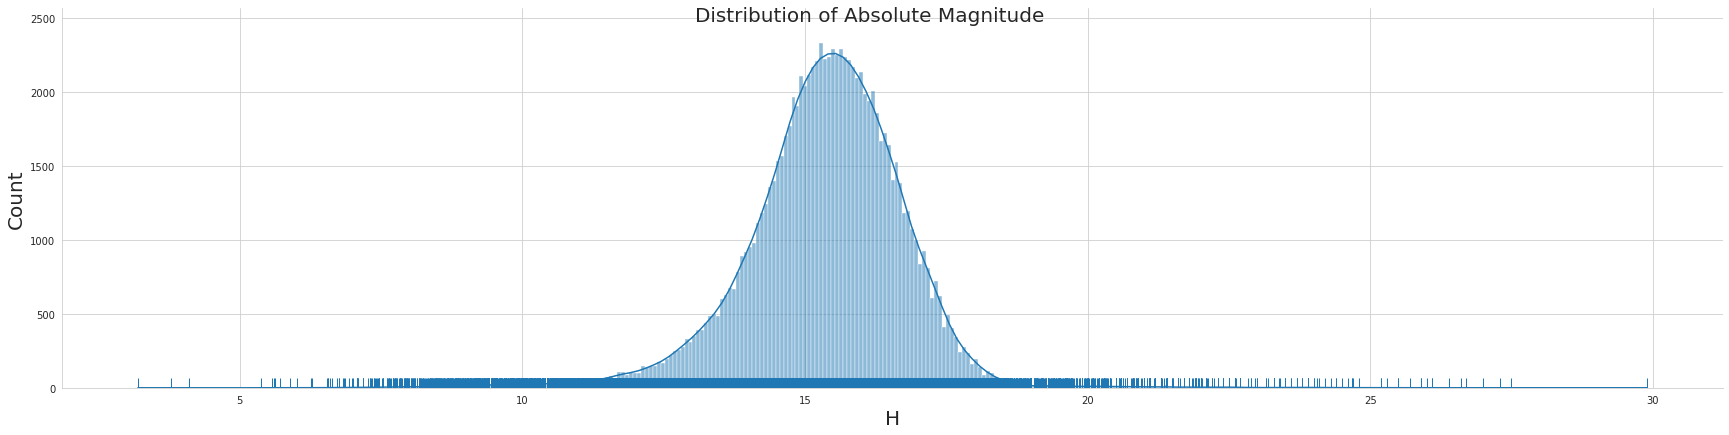

In [ ]:
#plotting H distribution
sns.set_style("whitegrid")
g = sns.displot(x=X_train.H, kde=True, rug=True, height=6, aspect=4)
g.set_xlabels(fontsize=20)
g.set_ylabels(fontsize=20)
g.fig.suptitle("Distribution of Absolute Magnitude", fontsize=20)
plt.show()


####Featurizing 'H' set-1:  optimal binning of feature 'H' with continous target 'diameter'
- Using here a python library called 'optbinning'
https://github.com/guillermo-navas-palencia/optbinning

In [ ]:
!pip install optbinning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 205 kB 5.2 MB/s 
     |████████████████████████████████| 15.5 MB 33.3 MB/s 
     |████████████████████████████████| 407 kB 70.5 MB/s 
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.17.3
    Uninstalling protobuf-3.17.3:
      Successfully uninstalled protobuf-3.17.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.9.0 requires protobuf<4,>=3.13, but you have protobuf 4.21.2 which is incompatible.
google-cloud-bigquery-storage 1.1.2 requires protobuf<4.0.0dev, but you have protobuf 4.21.2 which is incompatible.
google-api-core 1.31.6 requires protobuf<4.0.0dev,>=3.12.0; python_version > "3", but you have protobuf 4.21.2 which is incompatible.


In [ ]:
from optbinning import ContinuousOptimalBinning
# http://gnpalencia.org/optbinning/binning_continuous.html

In [ ]:
#making a copy of df
X_train_H_featurized_opt= X_train_imp_df.copy()
X_test_H_featurized_opt = X_test_imp_df.copy()

In [ ]:
#defining x and y for the bin fitting
variable = 'H'
train_H = X_train_H_featurized_opt['H'].values
test_H = X_test_H_featurized_opt['H'].values
train_y = y_train

In [ ]:
#defining binning object
optb1 = ContinuousOptimalBinning(name=variable, dtype="numerical", prebinning_method='cart')

In [ ]:
#fitting the method
optb1.fit(train_H, train_y)

ContinuousOptimalBinning(name='H')

In [ ]:
#check if optimal solution found
optb1.status

'OPTIMAL'

In [ ]:
#here are the splits
optb1.splits

array([13.03499985, 13.78499985, 14.15499973, 14.625     , 14.82499981,
       15.00500011, 15.16499996, 15.45499992, 15.625     , 15.80500031,
       16.06499958, 16.24499989, 16.51500034, 17.02500057])

In [ ]:
#save opt model
#joblib.dump(optb1, '/content/drive/MyDrive/project_asteroid/models/optb1.pkl')

['/content/drive/MyDrive/project_asteroid/models/optb1.pkl']

In [ ]:
optb1 = joblib.load('/content/drive/MyDrive/project_asteroid/models/optb1.pkl')

In [ ]:
#getting the binning_table
binning_table1 = optb1.binning_table

In [ ]:
#viewing bin table
binning_table1.build()

,Bin,Count,Count (%),Sum,Std,Mean,Min,Max,Zeros count,WoE,IV
0,"(-inf, 13.03)",4909,0.050197,130186.2290,35.163596,26.519908,4.2760,939.400,0,21.067121,1.057503
1,"[13.03, 13.78)",5558,0.056833,49961.9160,3.263545,8.989190,2.7230,20.131,0,3.536402,0.200985
2,"[13.78, 14.15)",4906,0.050166,34339.0320,2.47218,6.999395,1.7770,15.650,0,1.546608,0.077587
3,"[14.15, 14.62)",9062,0.092663,52728.3550,2.041634,5.818622,1.8610,17.050,0,0.365835,0.033899
4,"[14.62, 14.82)",5086,0.052007,26190.6160,1.801539,5.149551,1.7200,11.930,0,-0.303236,0.015770
5,"[14.82, 15.01)",5078,0.051925,24564.0940,1.671961,4.837356,1.4960,11.706,0,-0.615431,0.031956
6,"[15.01, 15.16)",4969,0.050810,22697.6110,1.585482,4.567843,1.5670,9.113,0,-0.884944,0.044964
7,"[15.16, 15.45)",10094,0.103216,41518.2830,1.534497,4.113165,0.3470,9.893,0,-1.339623,0.138270
8,"[15.45, 15.62)",5547,0.056721,22150.4220,1.352919,3.993226,1.2480,10.143,0,-1.459562,0.082787
9,"[15.62, 15.81)",5735,0.058643,22012.4940,1.240873,3.838273,1.1240,8.773,0,-1.614514,0.094680


In [ ]:
y_train.max()

939.4

In [ ]:
#transforming train and test data using mean as metric
H_transform_bins = optb1.transform(train_H, metric="mean")
H_test_bins = optb1.transform(test_H, metric="mean")

In [ ]:
type(H_transform_bins)

numpy.ndarray

In [ ]:
#drroping the original 'H'
X_train_H_featurized_opt.drop('H', axis=1, inplace=True)
#adding new feature to dataset 
X_train_H_featurized_opt['H'] = H_transform_bins


In [ ]:
#droping the original 'H'
X_test_H_featurized_opt.drop('H', axis=1, inplace=True)
#adding new feature to dataset
X_test_H_featurized_opt['H'] = H_test_bins


In [ ]:
X_train_H_featurized_opt.columns

Index(['albedo', 'epoch', 'e', 'a', 'q', 'i', 'ad', 'n', 'tp', 'per', 'moid',
       'moid_jup', 'data_arc', 'condition_code', 'rms', 'neo_Y', 'pha_Y',
       'class_APO', 'class_AST', 'class_ATE', 'class_CEN', 'class_IMB',
       'class_MBA', 'class_MCA', 'class_OMB', 'class_TJN', 'class_TNO', 'H'],
      dtype='object')

### Dataset_IV
- X_train_H_featurized_opt
- X_test_H_featurized_opt

Evaluating the dataset for diameter prediction with this new feature

In [ ]:
model_h_opt1 = LinearRegression()
metric = mean_absolute_error
mae_h_opt1, score_train_h_opt1, score_test_h_opt1 = evaluate(X_train_H_featurized_opt, y_train, X_test_H_featurized_opt, y_test, model_h_opt1, metric)

In [ ]:
print(f"MAE score with featurized 'H' dataset based on target diameter: {mae_h_opt1}")
print(f"Train score for Dataset_I is: {score_train_h_opt1}")
print(f"Test score for Dataset_I is: {score_test_h_opt1}")

MAE score with featurized 'H' dataset based on target diameter: 2.243916549171656
Train score for Dataset_I is: 0.4842526042377375
Test score for Dataset_I is: 0.41620483805542574


In [ ]:
datasets.append(('X_train_H_featurized_opt', 'X_test_H_featurized_opt'))
mae_datasets.append(mae_h_opt1)
train_scores.append(score_train_h_opt1)
test_scores.append(score_test_h_opt1)

In [ ]:
#save files
save_to_csv(X_train_H_featurized_opt, 'X_train_H_featurized_opt')
save_to_csv(X_test_H_featurized_opt, 'X_test_H_featurized_opt')

In [ ]:
#loading the dataframes from saved csv
X_train_H_featurized_opt = pd.read_csv('/content/drive/MyDrive/project_asteroid/data/X_train_H_featurized_opt')
X_test_H_featurized_opt = pd.read_csv('/content/drive/MyDrive/project_asteroid/data/X_test_H_featurized_opt')

#### Strategy - Decision tree based discreatization
- we observed that Absolue magnitude CDF gave a clear demarcations 
  - 'size_class' - based on domain info, classifying hierarchially based on size
  -  'size_kbin' - binning the diameter variable based on Kmeans clustering strategy
- we will do a Decision tree based discreatization of "H" based on binned diamter target feature('size_class' and 'size_kbin')
- We will create a two feature set. And evaluate these. If the featurization improves the error, we then consider adding to our dataframe with featurized set

### Featurizing 'H' set-2:  Discreatization based on target - binned diameter by kmeans

In [ ]:
#making a copy of df
X_train_H_featurized_1 = X_train_imp_df.copy()
X_test_H_featurized_1 = X_test_imp_df.copy()

In [ ]:
#making copy of target y_train
y_tr_continous = y_train.copy()

In [ ]:
## Using KBinsDiscretizer to binn traget diameter
from sklearn.preprocessing import KBinsDiscretizer

# kbin = KBinsDiscretizer(n_bins=4, encode="ordinal", strategy='kmeans')
# kbin.fit(y_tr_continous.values.reshape(-1,1))
# y_binned_train = kbin.transform(y_tr_continous.values.reshape(-1,1))

In [ ]:
import joblib
#joblib.dump(kbin, '/content/drive/MyDrive/project_asteroid/models/kbin.pkl')

In [ ]:
kbin_model = joblib.load('/content/drive/MyDrive/project_asteroid/models/kbin.pkl')

In [ ]:
kbin_model.bin_edges_

array([array([2.50000000e-03, 2.10775175e+01, 8.64747855e+01, 5.27565403e+02,
              9.39400000e+02])                                               ],
      dtype=object)

In [ ]:
y_binned_train= kbin_model.transform(y_tr_continous.values.reshape(-1,1))

In [ ]:
#looking at unique value and counts in y_binned_train
np.unique(y_binned_train, return_counts=True)

(array([0., 1., 2., 3.]), array([96049,  1521,   223,     2]))

In [ ]:
#converting 3. to 2.
y_binned_train = np.where(y_binned_train==3.0, 2., y_binned_train)

In [ ]:
# y_binned_train has now only three bins
np.unique(y_binned_train)

array([0., 1., 2.])

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

# applying decision tree algorithm
dt1 = DecisionTreeClassifier(max_depth=2, random_state=0)
#fitting on feature 'H' with target as binned diamter by Kbins
dt1.fit(X_train_H_featurized_1[['H']], y_binned_train)

DecisionTreeClassifier(max_depth=2, random_state=0)

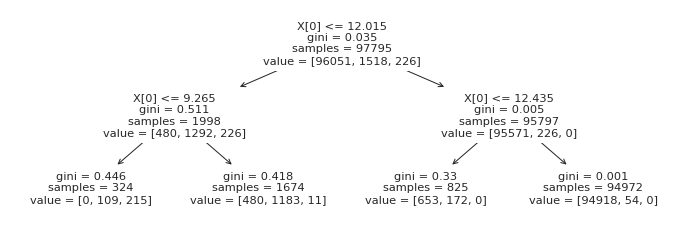

In [ ]:
# viewing the tress
fig, ax = plt.subplots(figsize=(12, 4))
plot_tree(dt1, ax=ax)
plt.show()

In [ ]:
# using Grid Search to tune hyperparamters - max_depth and estimator
from sklearn.model_selection import GridSearchCV
clf1 = DecisionTreeClassifier(random_state=0)
params = {'max_depth':[2, 3, 4, 5],
          'criterion': ['gini', 'entropy']}


gridCV1 = GridSearchCV(estimator=clf1, param_grid=params, cv=5, n_jobs=1, return_train_score=True)
gridCV1.fit(X_train_H_featurized_1[['H']], y_binned_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=0), n_jobs=1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 4, 5]},
             return_train_score=True)

In [ ]:
print(f"Best estimator: {gridCV1.best_estimator_}")
print(f"Best params: {gridCV1.best_params_}")
print(f"Best score: {gridCV1.best_score_}")

Best estimator: DecisionTreeClassifier(max_depth=4, random_state=0)
Best params: {'criterion': 'gini', 'max_depth': 4}
Best score: 0.991656015133698


In [ ]:
best_clf1 = gridCV1.best_estimator_
# joblib.dump(best_clf1, '/content/drive/MyDrive/project_asteroid/models/best_clf1.pkl')

In [ ]:
best_clf1 = joblib.load('/content/drive/MyDrive/project_asteroid/models/best_clf1.pkl')

In [ ]:
best_clf1.tree_.threshold

array([12.42500019, 10.73499966,  9.28499985,  7.60500002,  7.2349999 ,
       -2.        , -2.        ,  8.95499992, -2.        , -2.        ,
        9.69499969,  9.61499977, -2.        , -2.        , 10.14499998,
       -2.        , -2.        , 12.01500034, 11.375     , 11.20499992,
       -2.        , -2.        , 11.69499969, -2.        , -2.        ,
       12.32499981, 12.21500015, -2.        , -2.        , 12.33500004,
       -2.        , -2.        , 12.91499996, 12.625     , 12.43499994,
       -2.        , 12.59500027, -2.        , -2.        , 12.85500002,
       12.81500006, -2.        , -2.        , 12.89499998, -2.        ,
       -2.        , 13.19499969, 13.18499994, -2.        , -2.        ,
       16.75500011, -2.        , 16.76500034, -2.        , -2.        ])

In [ ]:
threshold = best_clf1.tree_.threshold[best_clf1.tree_.threshold>-2]
threshold = np.sort(threshold)
threshold

array([ 7.2349999 ,  7.60500002,  8.95499992,  9.28499985,  9.61499977,
        9.69499969, 10.14499998, 10.73499966, 11.20499992, 11.375     ,
       11.69499969, 12.01500034, 12.21500015, 12.32499981, 12.33500004,
       12.42500019, 12.43499994, 12.59500027, 12.625     , 12.81500006,
       12.85500002, 12.89499998, 12.91499996, 13.18499994, 13.19499969,
       16.75500011, 16.76500034])

In [ ]:
from sklearn.tree import export_text
tree_text1 = export_text(best_clf1, feature_names='H')
print(tree_text1)

|--- H <= 12.43
|   |--- H <= 10.73
|   |   |--- H <= 9.28
|   |   |   |--- H <= 7.61
|   |   |   |   |--- H <= 7.23
|   |   |   |   |   |--- class: 2.0
|   |   |   |   |--- H >  7.23
|   |   |   |   |   |--- class: 2.0
|   |   |   |--- H >  7.61
|   |   |   |   |--- H <= 8.95
|   |   |   |   |   |--- class: 2.0
|   |   |   |   |--- H >  8.95
|   |   |   |   |   |--- class: 1.0
|   |   |--- H >  9.28
|   |   |   |--- H <= 9.69
|   |   |   |   |--- H <= 9.61
|   |   |   |   |   |--- class: 1.0
|   |   |   |   |--- H >  9.61
|   |   |   |   |   |--- class: 1.0
|   |   |   |--- H >  9.69
|   |   |   |   |--- H <= 10.14
|   |   |   |   |   |--- class: 1.0
|   |   |   |   |--- H >  10.14
|   |   |   |   |   |--- class: 1.0
|   |--- H >  10.73
|   |   |--- H <= 12.02
|   |   |   |--- H <= 11.38
|   |   |   |   |--- H <= 11.20
|   |   |   |   |   |--- class: 1.0
|   |   |   |   |--- H >  11.20
|   |   |   |   |   |--- class: 1.0
|   |   |   |--- H >  11.38
|   |   |   |   |--- H <= 11.69
|   

In [ ]:
def generate_binned_H(data):
    h_kbinned=[]

    for H in data.values:
        if (H <= 12.43) & (H <= 10.73) & (H <= 9.28) & (H <= 7.61):
            h_kbinned.append(2)
        elif (H <= 12.43) & (H <= 10.73) & (H <= 9.28) & (H > 7.61) & (H <= 8.95):
            h_kbinned.append(2)
        elif (H <= 12.43) & (H <= 10.73) & (H <= 9.28) & (H > 7.61) & (H > 8.95):
            h_kbinned.append(1)
        elif (H <= 12.43) & (H <= 10.73) & (H > 9.28):
            h_kbinned.append(1)
        elif (H <= 12.43) & (H > 10.73) & (H <= 12.02) & (H <= 11.38):
            h_kbinned.append(1)
        elif (H <= 12.43) & (H > 10.73) & (H <= 12.02) & (H > 11.38) & (H <= 11.69):
            h_kbinned.append(1)
        elif (H <= 12.43) & (H > 10.73) & (H <= 12.02) & (H > 11.38) & (H > 11.69):
            h_kbinned.append(0)
        elif (H <= 12.43) & (H > 10.73) & (H > 12.02):
            h_kbinned.append(0)
        elif (H > 12.43):
            h_kbinned.append(0)
    return np.array(h_kbinned)

In [ ]:
train_h_binned = generate_binned_H(X_train_H_featurized_1.H)
test_h_binned = generate_binned_H(X_test_H_featurized_1.H)

In [ ]:
train_h_binned.shape, X_train_H_featurized_1.shape

((97795,), (97795, 28))

In [ ]:
test_h_binned.shape, X_test_H_featurized_1.shape

((41913,), (41913, 28))

In [ ]:
#drop original 'H' and add featurized 'H'
X_train_H_featurized_1.drop('H', axis=1, inplace=True)
X_train_H_featurized_1['H'] = train_h_binned


In [ ]:
#drop original 'H' and add featurized 'H'
X_test_H_featurized_1.drop('H', axis=1, inplace=True)
X_test_H_featurized_1['H'] = test_h_binned

### Dataset_V
- X_train_H_featurized_1
- X_test_H_featurized_1

Evaluating the featurized data

In [ ]:
## evaluating for thefetaurized dataset
model_h_kbin = LinearRegression()
metric = mean_absolute_error
mae_h1_kbin, score_train_h1_kbin, score_test_h1_kbin = evaluate(X_train_H_featurized_1, y_train, X_test_H_featurized_1, y_test, model_h_kbin, metric)


In [ ]:
print(f"MAE score with featurized 'H' dataset based on diameter kbins: {mae_h1_kbin}")
print(f"Train score for Dataset_I is: {score_train_h1_kbin}")
print(f"Test score for Dataset_I is: {score_test_h1_kbin}")

MAE score with featurized 'H' dataset based on diameter kbins: 1.7933822337101764
Train score for Dataset_I is: 0.6697213372907871
Test score for Dataset_I is: 0.6351207135936657


In [ ]:
datasets.append(('X_train_H_featurized_1', 'X_test_H_featurized_1'))
mae_datasets.append(mae_h1_kbin)
train_scores.append(score_train_h1_kbin)
test_scores.append(score_test_h1_kbin)

In [ ]:
#save files
save_to_csv(X_train_H_featurized_1, 'X_train_H_featurized_1')
save_to_csv(X_test_H_featurized_1, 'X_test_H_featurized_1')

In [ ]:
#loading the dataframes from saved csv
X_train_H_featurized_1 = pd.read_csv('/content/drive/MyDrive/project_asteroid/data/X_train_H_featurized_1')
X_test_H_featurized_1 = pd.read_csv('/content/drive/MyDrive/project_asteroid/data/X_test_H_featurized_1')

### Featurizing 'H' set-3: Discreatization based on target - binned diameter by size

In [ ]:
#making a copy of df
X_train_H_featurized_2 = X_train_imp_df.copy()
X_test_H_featurized_2 = X_test_imp_df.copy()

In [ ]:
def size_bin(x):
    if x<=1:
        sizebin='s1'
    elif x>1 and x<=10:
        sizebin='s2'
    elif x>10 and x<=100:
        sizebin='s3'
    elif x>100:
        sizebin='s4'
    return sizebin

In [ ]:
# binning train and test target variables by size_class
y_tr_binned_size = y_tr_continous.apply(size_bin)

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

# applying decision tree algorithm
dt2 = DecisionTreeClassifier(max_depth=2, random_state=0)
dt2.fit(X_train_H_featurized_2[['H']], y_tr_binned_size)

DecisionTreeClassifier(max_depth=2, random_state=0)

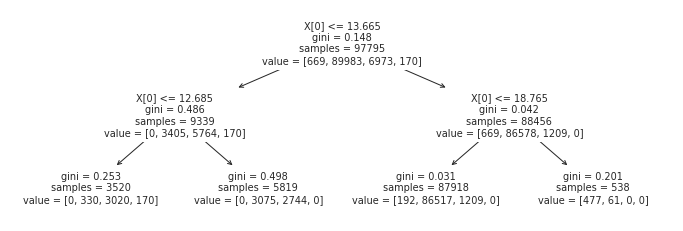

In [ ]:
# viewing the tress
fig, ax = plt.subplots(figsize=(12, 4))
plot_tree(dt2, ax=ax)
plt.show()

In [ ]:
# using Grid Search to tune hyperparamters - max_depth and estimator
from sklearn.model_selection import GridSearchCV
clf2 = DecisionTreeClassifier(random_state=0)
params = {'max_depth':[2, 3, 4, 5],
          'criterion': ['gini', 'entropy']}


gridCV2 = GridSearchCV(estimator=clf2, param_grid=params, cv=5, n_jobs=1, return_train_score=True)
gridCV2.fit(X_train_H_featurized_2[['H']], y_tr_binned_size)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=0), n_jobs=1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 4, 5]},
             return_train_score=True)

In [ ]:
print(f"Best estimator: {gridCV2.best_estimator_}")
print(f"Best params: {gridCV2.best_params_}")
print(f"Best score: {gridCV2.best_score_}")

Best estimator: DecisionTreeClassifier(max_depth=5, random_state=0)
Best params: {'criterion': 'gini', 'max_depth': 5}
Best score: 0.9548545426657805


In [ ]:
best_clf2 = gridCV2.best_estimator_
best_clf2.tree_.threshold

array([13.66499996, 12.68499994,  9.00500011,  7.45499992,  7.0400002 ,
       -2.        , -2.        ,  8.85500002, -2.        , -2.        ,
       12.25500011, 11.92500019, -2.        , -2.        , 12.49499989,
       -2.        , -2.        , 13.2750001 , 12.90499973, 12.85500002,
       -2.        , -2.        , 13.11499977, -2.        , -2.        ,
       13.46500015, 13.42500019, -2.        , -2.        , 13.625     ,
       -2.        , -2.        , 18.76500034, 14.07499981, 13.91499996,
       13.79500008, -2.        , -2.        , 13.92500019, -2.        ,
       -2.        , 18.17500019, 14.24499989, -2.        , -2.        ,
       18.45499992, -2.        , -2.        , 19.52500057, 19.02499962,
       18.8949995 , -2.        , -2.        , 19.49499989, -2.        ,
       -2.        , 20.08500004, 20.07499981, -2.        , -2.        ,
       -2.        ])

In [ ]:
best_clf2 = gridCV2.best_estimator_
# joblib.dump(best_clf2, '/content/drive/MyDrive/project_asteroid/models/best_clf2.pkl')

['/content/drive/MyDrive/project_asteroid/models/best_clf2.pkl']

In [ ]:
best_clf2 = joblib.load('/content/drive/MyDrive/project_asteroid/models/best_clf2.pkl')

In [ ]:
threshold2 = best_clf2.tree_.threshold[best_clf2.tree_.threshold>-2]
threshold2 = np.sort(threshold2)
threshold2

array([ 7.0400002 ,  7.45499992,  8.85500002,  9.00500011, 11.92500019,
       12.25500011, 12.49499989, 12.68499994, 12.85500002, 12.90499973,
       13.11499977, 13.2750001 , 13.42500019, 13.46500015, 13.625     ,
       13.66499996, 13.79500008, 13.91499996, 13.92500019, 14.07499981,
       14.24499989, 18.17500019, 18.45499992, 18.76500034, 18.8949995 ,
       19.02499962, 19.49499989, 19.52500057, 20.07499981, 20.08500004])

In [ ]:
from sklearn.tree import export_text

tree_rules = export_text(best_clf2, feature_names='H')
print(tree_rules)

|--- H <= 13.66
|   |--- H <= 12.68
|   |   |--- H <= 9.01
|   |   |   |--- H <= 7.45
|   |   |   |   |--- H <= 7.04
|   |   |   |   |   |--- class: s4
|   |   |   |   |--- H >  7.04
|   |   |   |   |   |--- class: s4
|   |   |   |--- H >  7.45
|   |   |   |   |--- H <= 8.86
|   |   |   |   |   |--- class: s4
|   |   |   |   |--- H >  8.86
|   |   |   |   |   |--- class: s3
|   |   |--- H >  9.01
|   |   |   |--- H <= 12.26
|   |   |   |   |--- H <= 11.93
|   |   |   |   |   |--- class: s3
|   |   |   |   |--- H >  11.93
|   |   |   |   |   |--- class: s3
|   |   |   |--- H >  12.26
|   |   |   |   |--- H <= 12.49
|   |   |   |   |   |--- class: s3
|   |   |   |   |--- H >  12.49
|   |   |   |   |   |--- class: s3
|   |--- H >  12.68
|   |   |--- H <= 13.28
|   |   |   |--- H <= 12.90
|   |   |   |   |--- H <= 12.86
|   |   |   |   |   |--- class: s3
|   |   |   |   |--- H >  12.86
|   |   |   |   |   |--- class: s3
|   |   |   |--- H >  12.90
|   |   |   |   |--- H <= 13.11
|   |   | 

In [ ]:
def get_h_binned_by_size(data):
    h_kbinned=[]

    for H in data.values:
            if (H <= 13.66) & (H <= 12.68) & (H <= 9.01) & (H <= 7.45):
                      h_kbinned.append(4)
            elif (H <= 13.66) & (H <= 12.68) & (H <= 9.01) & (H > 7.45) & (H <= 8.86):
                      h_kbinned.append(4)
            elif (H <= 13.66) & (H <= 12.68) & (H <= 9.01) & (H > 7.45) & (H > 8.86):
                      h_kbinned.append(3)
            elif (H <= 13.66) & (H <= 12.68) & (H > 9.01):
                      h_kbinned.append(3)
            elif (H <= 13.66) & (H > 12.68) & (H <= 13.28) & (H <= 12.90):
                      h_kbinned.append(3)
            elif (H <= 13.66) & (H > 12.68) & (H <= 13.28) & (H > 12.90) & (H <= 13.11):
                      h_kbinned.append(3)
            elif (H <= 13.66) & (H > 12.68) & (H <= 13.28) & (H > 12.90) & (H > 13.11):
                      h_kbinned.append(2)
            elif (H <= 13.66) & (H > 12.68) & (H > 13.28):
                      h_kbinned.append(2)
            elif (H > 13.66) & (H <= 18.77):
                      h_kbinned.append(2)
            elif (H > 13.66) & (H > 18.77) & (H <= 19.53) & (H <= 19.02) & (H <= 18.89):
                      h_kbinned.append(1)
            elif (H > 13.66) & (H > 18.77) & (H <= 19.53) & (H <= 19.02) & (H > 18.89):
                      h_kbinned.append(2)
            elif (H > 13.66) & (H > 18.77) & (H <= 19.53) & (H > 19.02):
                      h_kbinned.append(1)
            elif (H > 13.66) & (H > 18.77) & (H > 19.53):
                      h_kbinned.append(1)
    return np.array(h_kbinned)

In [ ]:
train_h_binned_size = get_h_binned_by_size(X_train_H_featurized_2.H)
test_h_binned_size = get_h_binned_by_size(X_test_H_featurized_2.H)

In [ ]:
train_h_binned_size.shape, X_train_H_featurized_2.shape

((97795,), (97795, 28))

In [ ]:
test_h_binned_size.shape, X_test_H_featurized_2.shape

((41913,), (41913, 28))

In [ ]:
#drop original 'H' and add featurized 'H'
X_train_H_featurized_2.drop('H', axis=1, inplace=True)
X_train_H_featurized_2['H'] = train_h_binned_size


In [ ]:
#drop original 'H' and add featurized 'H'
X_test_H_featurized_2.drop('H', axis=1, inplace=True)
X_test_H_featurized_2['H'] = test_h_binned_size

### Dataset_VI
- X_train_H_featurized_2
- X_test_H_featurized_2

Evaluating the featurized data

In [ ]:
## evaluating for thefetaurized dataset
model_h_bin_size = LinearRegression()
metric = mean_absolute_error
mae_h_bin_size, score_train_h_bin_size, score_test_h_bin_size = evaluate(X_train_H_featurized_2, y_train, X_test_H_featurized_2, y_test, model_h_bin_size, metric)

In [ ]:
print(f"MAE score with featurized 'H' dataset based on diameter kbins: {mae_h_bin_size}")
print(f"Train score for Dataset_I is: {score_train_h_bin_size}")
print(f"Test score for Dataset_I is: {score_test_h_bin_size}")

MAE score with featurized 'H' dataset based on diameter kbins: 2.2754171095167006
Train score for Dataset_I is: 0.519860805537821
Test score for Dataset_I is: 0.46310235981569137


In [ ]:
#updating dataset and score list
datasets.append(('X_train_H_featurized_2', 'X_test_H_featurized_2'))
mae_datasets.append(mae_h_bin_size)
train_scores.append(score_train_h_bin_size)
test_scores.append(score_test_h_bin_size)

In [ ]:
#save files
save_to_csv(X_train_H_featurized_2, 'X_train_H_featurized_2')
save_to_csv(X_test_H_featurized_2, 'X_test_H_featurized_2')

In [ ]:
#loading the dataframes from saved csv
X_train_H_featurized_2 = pd.read_csv('/content/drive/MyDrive/project_asteroid/data/X_train_H_featurized_2')
X_test_H_featurized_2 = pd.read_csv('/content/drive/MyDrive/project_asteroid/data/X_test_H_featurized_2')

## We have got three Datasets from H featurization here:
- Dataset IV: X_train_H_featurized_opt, X_test_H_featurized_opt
- Dataset_V: X_train_H_featurized_1, X_test_H_featurized_1 (based on kbinned diameter)
- Dataset_VI: X_train_H_featurized_2,  X_test_H_featurized_2 (based size binned diameter)
we will explore these during Modelling

## Numerical Feature Transformation - Scaling/Distribution Specific

Since scaling and distribution are very much model specific, we will try these transformation during Modelling

[]

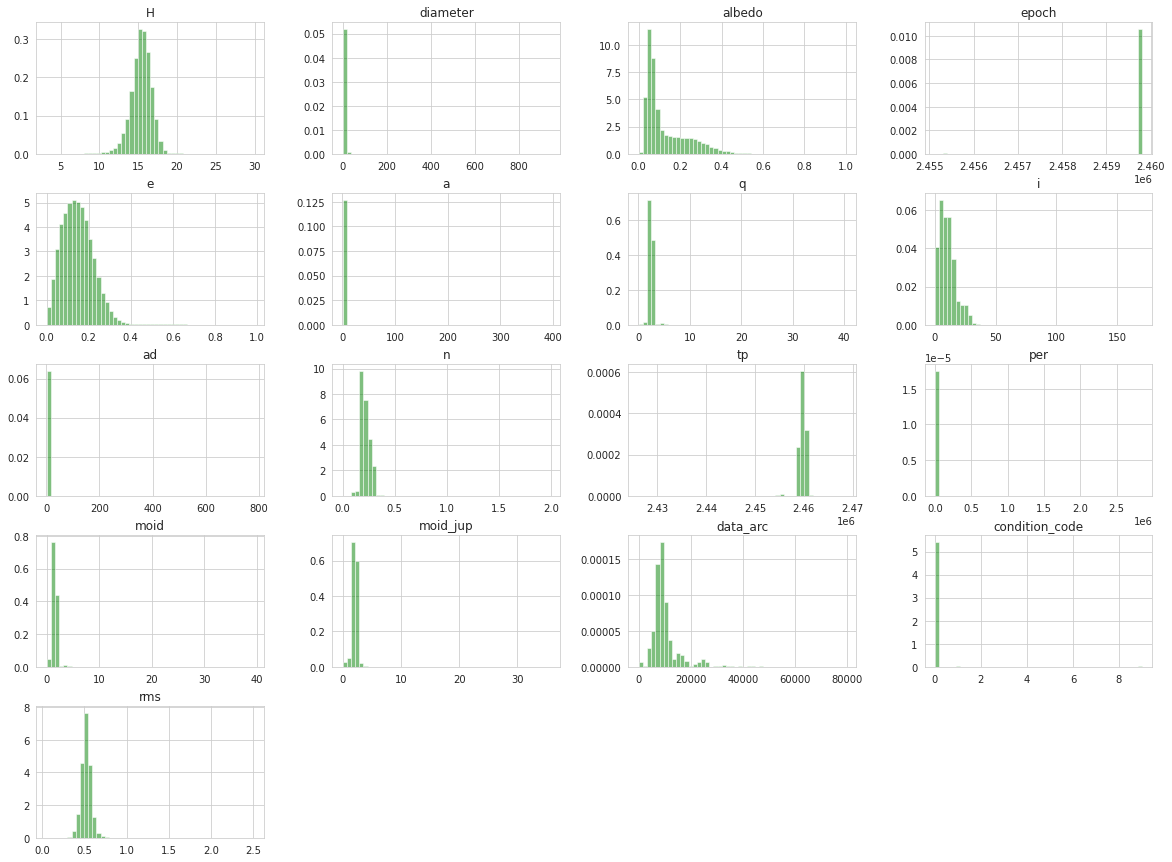

In [ ]:
dfe.hist(bins=50, figsize=(20, 15), color='g', alpha=0.5, density=True)
plt.plot()

Observations:
- features are in varied scales
- features are of varied distribution

In [ ]:
numerical_features = X_train.dtypes[(X_train.dtypes=="float64")|(X_train.dtypes=="int64")].index.values.tolist()

In [ ]:
print(numerical_features)

['H', 'albedo', 'epoch', 'e', 'a', 'q', 'i', 'ad', 'n', 'tp', 'per', 'moid', 'moid_jup', 'data_arc', 'condition_code', 'rms']


## Creating a final featurized datasets having both featurized orbit class and featurized 'H'

In [ ]:
datasets

[('X_train_imp_df', 'X_test_imp_df'),
 ('X_train_class_featured1', 'X_test_class_featured1'),
 ('X_train_class_featured2', 'X_test_class_featured2'),
 ('X_train_H_featurized_opt', 'X_test_H_featurized_opt'),
 ('X_train_H_featurized_1', 'X_test_H_featurized_1'),
 ('X_train_H_featurized_2', 'X_test_H_featurized_2')]

### Dataset_VII: Concatenated featurized_set_1
This set will have featurized Orbit_class(X_train_class_featured1) and featurized 'H'(X_train_H_featurized_1) which was generated using supervised method based on target Kbinned-diameter

In [ ]:
# creating final featurized train set
X_train_featurized_1 = X_train_class_featured1.copy().drop('H', axis=1)
X_train_featurized_1['H'] = X_train_H_featurized_1.H

In [ ]:
# same for test set
X_test_featurized_1 = X_test_class_featured1.copy().drop('H', axis=1)
X_test_featurized_1['H'] = X_test_H_featurized_1.H

In [ ]:
X_train_featurized_1.shape, X_test_featurized_1.shape

((97795, 20), (41913, 20))

Evaluate featurized set 1

In [ ]:
## evaluating for thefetaurized dataset
model_featuredset_1 = LinearRegression()
metric = mean_absolute_error
mae_featuredset_1, score_train_featured1, score_test_featured1 = evaluate(X_train_featurized_1, y_train, X_test_featurized_1, y_test, model_featuredset_1, metric)

In [ ]:
print(f"MAE score for featurized set 1: {mae_featuredset_1}")
print(f"Train score for featurized set 1 is: {score_train_featured1}")
print(f"Test score for featurized set 1 is: {score_test_featured1}")

MAE score for featurized set 1: 1.8486564693038776
Train score for featurized set 1 is: 0.6643403819437377
Test score for featurized set 1 is: 0.6377282604355577


In [ ]:
#updating dataset and score list
datasets.append(('X_train_featurized_1', 'X_test_featurized_1'))
mae_datasets.append(mae_featuredset_1)
train_scores.append(score_train_featured1)
test_scores.append(score_test_featured1)

In [ ]:
#save files
save_to_csv(X_train_featurized_1, 'X_train_featurized_1')
save_to_csv(X_test_featurized_1, 'X_test_featurized_1')

In [ ]:
#loading the dataframes from saved csv
X_train_featurized_1 = pd.read_csv('/content/drive/MyDrive/project_asteroid/data/X_train_featurized_1')
X_test_featurized_1 = pd.read_csv('/content/drive/MyDrive/project_asteroid/data/X_test_featurized_1')

Observation:
- mae score was better with dataset having original orbit class encodings

### Dataset_VIII: Concatenated featurized_set_2
This set will have featurized Orbit_class(X_train_class_featured2) and featurized 'H'(X_train_H_featurized_2) which was generated using supervised method based on target size_binned-diameter

In [ ]:
# creating final featurized train set
X_train_featurized_2 = X_train_class_featured2.copy().drop('H', axis=1)
X_train_featurized_2['H'] = X_train_H_featurized_2.H

In [ ]:
# same for test set
X_test_featurized_2 = X_test_class_featured2.copy().drop('H', axis=1)
X_test_featurized_2['H'] = X_test_H_featurized_2.H

In [ ]:
X_train_featurized_2.shape, X_test_featurized_2.shape

((97795, 22), (41913, 22))

Evaluate featurized set 2

In [ ]:
## evaluating for thefetaurized dataset
model_featuredset_2 = LinearRegression()
metric = mean_absolute_error
mae_featuredset_2, score_train_featured2, score_test_featured2 = evaluate(X_train_featurized_2, y_train, X_test_featurized_2, y_test, model_featuredset_2, metric)

In [ ]:
print(f"MAE for featurized set 2: {mae_featuredset_2}")
print(f"Train score for featurized set 2: {score_train_featured2}")
print(f"Test score featurized set 2: {score_test_featured2}")

MAE for featurized set 2: 2.3212009363548707
Train score for featurized set 2: 0.5179471926421977
Test score featurized set 2: 0.46514754021022764


In [ ]:
#updating dataset and score list
datasets.append(('X_train_featurized_2', 'X_test_featurized_2'))
mae_datasets.append(mae_featuredset_2)
train_scores.append(score_train_featured2)
test_scores.append(score_test_featured2)

In [ ]:
#save files
save_to_csv(X_train_featurized_2, 'X_train_featurized_2')
save_to_csv(X_test_featurized_2, 'X_test_featurized_2')

In [ ]:
#loading the dataframes from saved csv
X_train_featurized_2 = pd.read_csv('/content/drive/MyDrive/project_asteroid/data/X_train_featurized_2')
X_test_featurized_2 = pd.read_csv('/content/drive/MyDrive/project_asteroid/data/X_test_featurized_2')

### Dataset_IX: Concatenated featurized_set_3
To the Orbit class featurized set 1(X_train_class_featured1) dataset, we will add featurized 'H' from X_train_H_featurized_opt which was generated using optimal binning method based on continous target diameter values

In [ ]:
datasets

[('X_train_imp_df', 'X_test_imp_df'),
 ('X_train_class_featured1', 'X_test_class_featured1'),
 ('X_train_class_featured2', 'X_test_class_featured2'),
 ('X_train_H_featurized_opt', 'X_test_H_featurized_opt'),
 ('X_train_H_featurized_1', 'X_test_H_featurized_1'),
 ('X_train_H_featurized_2', 'X_test_H_featurized_2'),
 ('X_train_featurized_1', 'X_test_featurized_1'),
 ('X_train_featurized_2', 'X_test_featurized_2')]

In [ ]:
X_train_class_featured1.columns

Index(['H', 'albedo', 'epoch', 'e', 'a', 'q', 'i', 'ad', 'n', 'tp', 'per',
       'moid', 'moid_jup', 'data_arc', 'condition_code', 'rms', 'neo_Y',
       'pha_Y', 'orbit_class_c2', 'orbit_class_c3'],
      dtype='object')

In [ ]:
# featurized column H_optbin1
X_train_H_featurized_opt.columns

Index(['albedo', 'epoch', 'e', 'a', 'q', 'i', 'ad', 'n', 'tp', 'per', 'moid',
       'moid_jup', 'data_arc', 'condition_code', 'rms', 'neo_Y', 'pha_Y',
       'class_APO', 'class_AST', 'class_ATE', 'class_CEN', 'class_IMB',
       'class_MBA', 'class_MCA', 'class_OMB', 'class_TJN', 'class_TNO', 'H'],
      dtype='object')

In [ ]:
# creating final featurized train set
X_train_featurized_3 = X_train_class_featured1.copy().drop('H', axis=1)
X_train_featurized_3['H'] = X_train_H_featurized_opt.H

In [ ]:
# same for test set
X_test_featurized_3 = X_test_class_featured1.copy().drop('H', axis=1)
X_test_featurized_3['H'] = X_test_H_featurized_opt.H

In [ ]:
X_test_featurized_3.columns

Index(['albedo', 'epoch', 'e', 'a', 'q', 'i', 'ad', 'n', 'tp', 'per', 'moid',
       'moid_jup', 'data_arc', 'condition_code', 'rms', 'neo_Y', 'pha_Y',
       'orbit_class_c2', 'orbit_class_c3', 'H'],
      dtype='object')

In [ ]:
#check shapes
X_train_featurized_3.shape, X_test_featurized_3.shape

((97795, 20), (41913, 20))

Evaluate featurized set 3

In [ ]:
## evaluating for thefetaurized dataset
model_featuredset_3 = LinearRegression()
metric = mean_absolute_error
mae_featuredset_3, score_train_featured3, score_test_featured3 = evaluate(X_train_featurized_3, y_train, X_test_featurized_3, y_test, model_featuredset_2, metric)

In [ ]:
print(f"MAE score with featurized 'H' dataset based on diameter kbins: {mae_featuredset_3}")
print(f"Train score for Dataset_I is: {score_train_featured3}")
print(f"Test score for Dataset_I is: {score_test_featured3}")

MAE score with featurized 'H' dataset based on diameter kbins: 2.339325958933692
Train score for Dataset_I is: 0.47714136449990663
Test score for Dataset_I is: 0.425647766714104


In [ ]:
#updating dataset and score list
datasets.append(('X_train_featurized_3', 'X_test_featurized_3'))
mae_datasets.append(mae_featuredset_3)
train_scores.append(score_train_featured3)
test_scores.append(score_test_featured3)

In [ ]:
#saving files
save_to_csv(X_train_featurized_3, 'X_train_featurized_3')
save_to_csv(X_test_featurized_3, 'X_test_featurized_3')

In [ ]:
#loading the dataframes from saved csv
X_train_featurized_3 = pd.read_csv('/content/drive/MyDrive/project_asteroid/data/X_train_featurized_3')
X_train_featurized_3 = pd.read_csv('/content/drive/MyDrive/project_asteroid/data/X_train_featurized_3')

## Note: We have at this stage 9 feature sets:
Lets review it

In [ ]:
Datasets_scores = pd.DataFrame({'Dataset':datasets, 'LR_MAE_Scores':mae_datasets, 'Train Score':train_scores, 'Test Score': test_scores})
Datasets_scores

,Dataset,LR_MAE_Scores,Train Score,Test Score
0,"(X_train_imp_df, X_test_imp_df)",2.519004,0.517023,0.451986
1,"(X_train_class_featured1, X_test_class_featured1)",2.582081,0.511893,0.463163
2,"(X_train_class_featured2, X_test_class_featured2)",2.582278,0.513076,0.459607
3,"(X_train_H_featurized_opt, X_test_H_featurized...",2.243917,0.484253,0.416205
4,"(X_train_H_featurized_1, X_test_H_featurized_1)",1.793382,0.669721,0.635121
5,"(X_train_H_featurized_2, X_test_H_featurized_2)",2.275417,0.519861,0.463102
6,"(X_train_featurized_1, X_test_featurized_1)",1.848656,0.664340,0.637728
7,"(X_train_featurized_2, X_test_featurized_2)",2.321201,0.517947,0.465148
8,"(X_train_featurized_3, X_test_featurized_3)",2.339326,0.477141,0.425648


## Log-transformation of the target variable

We know that the target variable diameter is skewed, we observed that in the EDA study. lets look at y_train distribution:

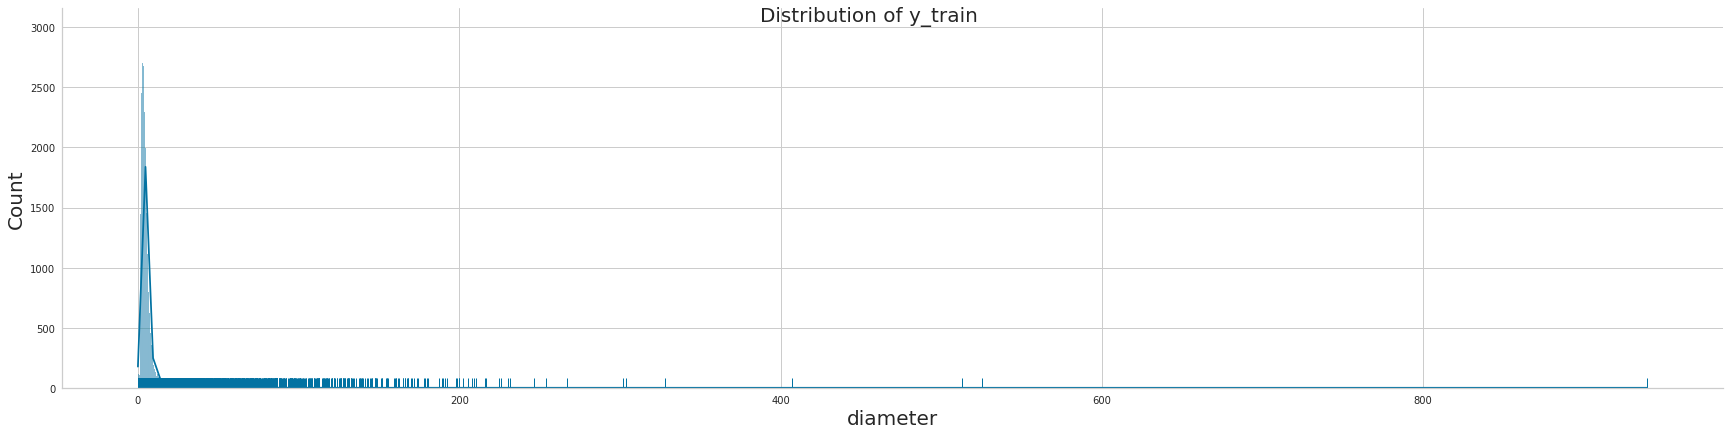

In [ ]:
#plotting y_train distribution
sns.set_style("whitegrid")
g = sns.displot(x=y_train, kde=True, rug=True, height=6, aspect=4)
g.set_xlabels(fontsize=20)
g.set_ylabels(fontsize=20)
g.fig.suptitle("Distribution of y_train", fontsize=20)
plt.show()

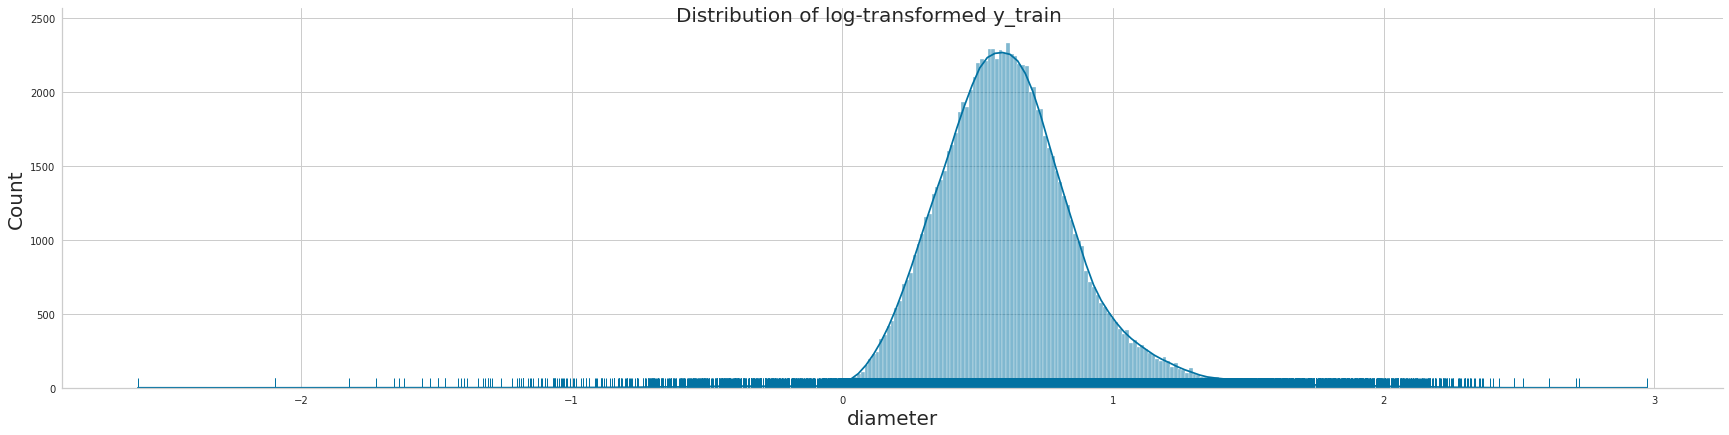

In [ ]:
#plotting log transformed y_train distribution
sns.set_style("whitegrid")
g = sns.displot(x=np.log10(y_train), kde=True, rug=True, height=6, aspect=4)
g.set_xlabels(fontsize=20)
g.set_ylabels(fontsize=20)
g.fig.suptitle("Distribution of log-transformed y_train", fontsize=20)
plt.show()


log-transformed y-train distribution looks better

In [ ]:
y_train_skewness = round(scipy.stats.skew(y_train, axis=0),3)
print(f"y_train_skewness: {y_train_skewness}")

y_train_skewness: 29.11


In [ ]:
log_y_train_skewness = round(scipy.stats.skew(np.log10(y_train), axis=0),3)
print(f"log transformed y_train_skewness: {log_y_train_skewness}")

log transformed y_train_skewness: 0.522


the skewness scores also look significantly better, log transformation helped reducing the skewness

Lets evaluate if target log-transformation will be helpful

In [ ]:
y_train_log = np.log1p(y_train)

In [ ]:
y_train.shape, y_train_log.shape

((97795,), (97795,))

- Evaluate with y_train, y_test

In [ ]:
# defining a function evaluate multiple dataset
from sklearn.metrics import r2_score

def evaluate_datasets(datasets, y_train_log, y_test, model, metric):
      mae_scores = []
      train_scores = []
      test_scores = []
      for i in range(len(datasets)):
            train, test = eval(datasets[i][0]).copy(), eval(datasets[i][1]).copy()
            
            #standardize data
            scaler=StandardScaler()
            scaler.fit(train)
            train = scaler.transform(train)
            test = scaler.transform(test)

            #define model
            model = model
            metric = metric
            
            #fit and predict
            model.fit(train, y_train_log)

            #predict train
            y_train_pred_log = model.predict(train)
            y_train_pred = np.expm1(y_train_pred_log)

            #predict test
            y_pred_log= model.predict(test)
            y_pred = np.expm1(y_pred_log) 

            mae_test = metric(y_test, y_pred)
            mae_scores.append(mae_test)
            train_scores.append(r2_score(y_train, y_train_pred))
            test_scores.append(r2_score(y_test, y_pred))

      result_summary = pd.DataFrame({'Datasets':datasets, 'Mae Scores':mae_scores, 'Train_scores':train_scores, 'Test_scores':test_scores})

      return result_summary, mae_scores

- Evaluate with log transformed y_train, y_test

In [ ]:
model=LinearRegression()
metric = mean_absolute_error
result_df, mae_log = evaluate_datasets(datasets, y_train_log, y_test, model, metric)
result_df

,Datasets,Mae Scores,Train_scores,Test_scores
0,"(X_train_imp_df, X_test_imp_df)",0.781107,0.779240,0.825954
1,"(X_train_class_featured1, X_test_class_featured1)",0.784722,0.828753,0.827263
2,"(X_train_class_featured2, X_test_class_featured2)",0.783483,0.795377,0.828564
3,"(X_train_H_featurized_opt, X_test_H_featurized...",1.460086,-0.197422,0.560686
4,"(X_train_H_featurized_1, X_test_H_featurized_1)",1.454339,-1.907079,0.686076
5,"(X_train_H_featurized_2, X_test_H_featurized_2)",1.471181,-2.057298,0.632194
6,"(X_train_featurized_1, X_test_featurized_1)",1.475526,-1.298997,0.702049
7,"(X_train_featurized_2, X_test_featurized_2)",1.475004,-9.321868,0.648223
8,"(X_train_featurized_3, X_test_featurized_3)",1.460086,-0.197422,0.560686


Observation:
- MAE score seems to improved
- R2 score for train is terrible
- Choose not to go with these transformations

## Feature Importance in the generated datasets

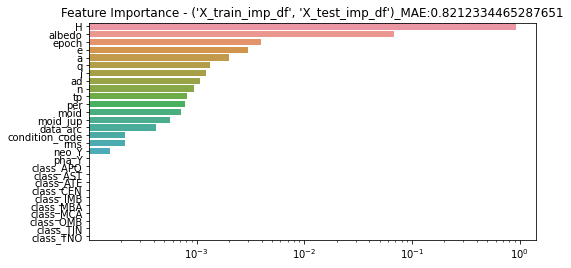

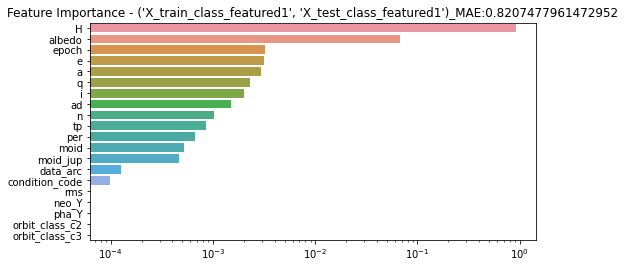

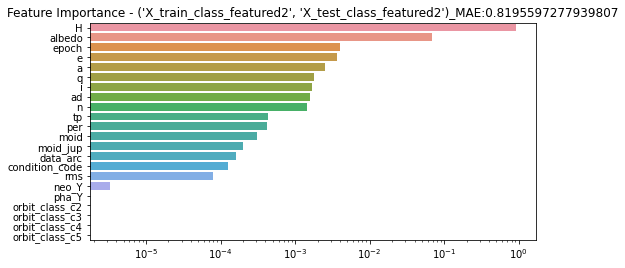

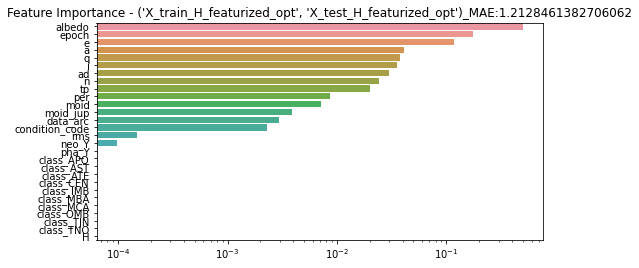

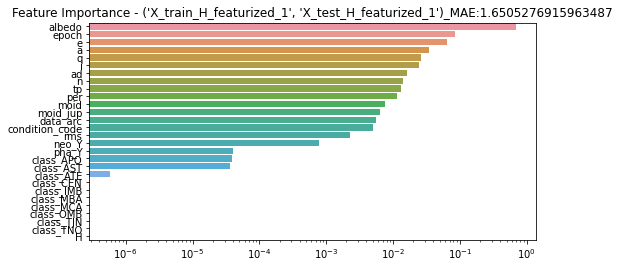

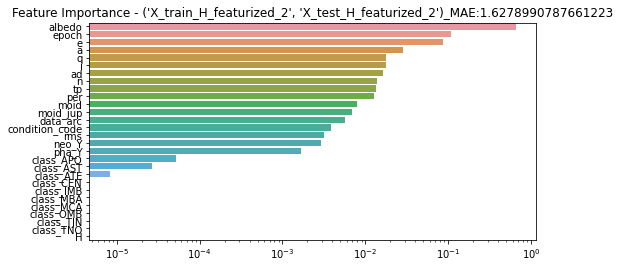

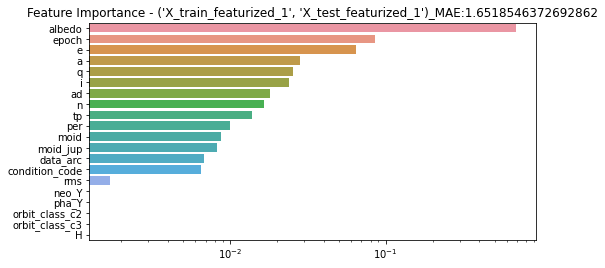

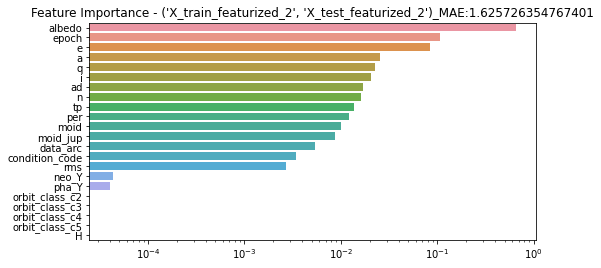

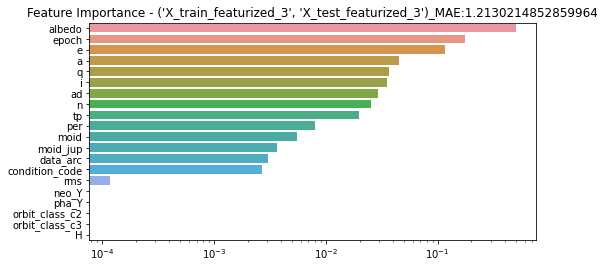

In [ ]:
#lets look at the Feature importance 
from sklearn.ensemble import RandomForestRegressor

mae_rf_scores_dataset=[]
for dataset in datasets:
      train_data = eval(dataset[0])
      test_data = eval(dataset[1])
      lr = LinearRegression()
      rf1 = RandomForestRegressor(n_estimators=100, n_jobs=-1, max_depth=5, random_state=42)
      mae_rf1, train_score_rf1, test_score_rf1= evaluate(train_data, y_train, test_data, y_test, rf1, metric)
      mae_rf_scores_dataset.append(mae_rf1)

      plot_feature_imp(rf1, train_data, f'{dataset}_MAE:{mae_rf1}')

In [ ]:
Datasets_scores['RF_MAE_Scores'] = mae_rf_scores_dataset
Datasets_scores.insert(0, '#', [f'Dataset_{i}' for i in range(1, 10)])

### Feature Importance Observation:
- **'H', albedo, epoch, 'e', 'a', 'q', 'i', 'ad', 'n', 'tp', 'per', moid, moid_jup, data_arc, condition_code, rms, neo_Y**

## Testing feature Collinearity  for all datasets

##### Computing VIF with cut-off of 5

In [ ]:
# computing variance_inflation_factor value for the independent variables
from statsmodels.stats.outliers_influence import variance_inflation_factor

def compute_vif(train_data, feature_set):
      """ function to compute vif and plot graph, return list of collinear features and new data with removed features"""
      vif = [variance_inflation_factor(train_data.values, i) for i in range(train_data.shape[1])]
      #dataframe - feature VIF values
      vif_df = pd.DataFrame({'vif_value': vif}, index=train_data.columns).sort_values('vif_value', ascending=False)

      ##plot graph
      xlabels =[i for i in vif_df.index]
      fig, ax = plt.subplots(figsize=(8,4))
      ax = sns.barplot(x=vif_df.index,y="vif_value", data=vif_df)
      ax.set(yscale='log')
      ax.set_xticklabels(labels=xlabels, rotation=70)
      ax.set_title(f'VIF score - {feature_set}')
      plt.plot()

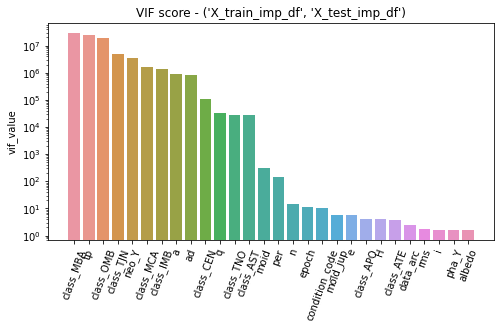

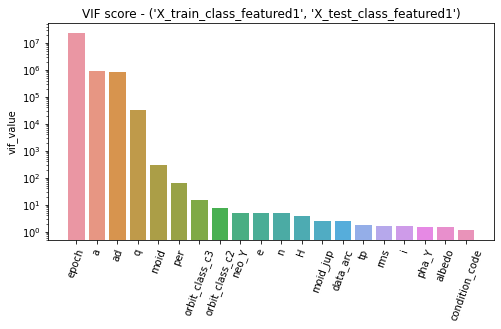

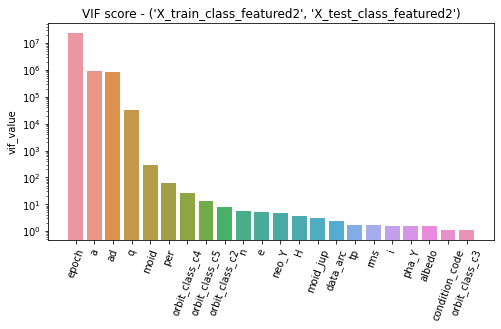

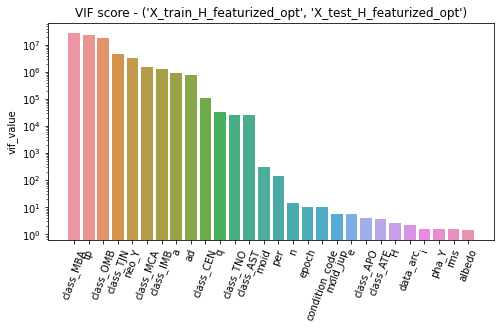

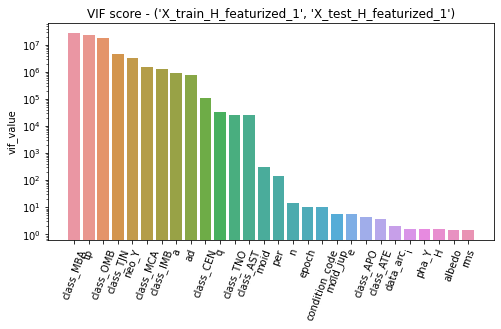

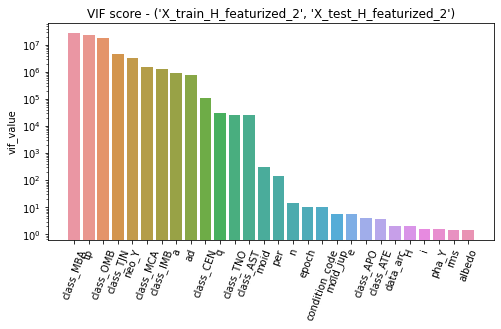

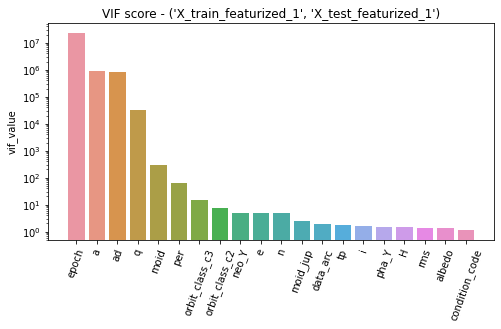

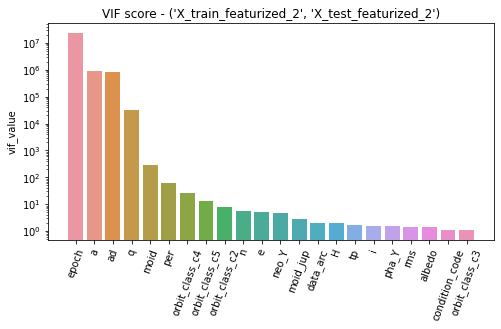

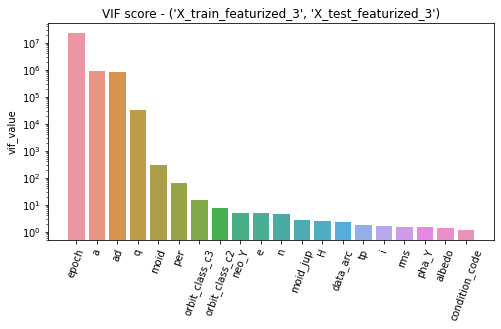

In [ ]:
## computing VIF for the feature sets
for i in range(len(datasets)):
    train_data = eval(datasets[i][0]).copy()
    compute_vif(train_data, datasets[i])

## Remove highly collinear features

In [ ]:
def remove_high_vifs(train_data):
      """ function to compute vif and plot graph, return list of collinear features and new data with removed features"""

      drop = True
      collinear_features = []
      while drop:
          vif = [variance_inflation_factor(train_data.values, i) for i in range(train_data.shape[1])]

          #dataframe - feature VIF values
          vif_df = pd.DataFrame({'vif_value': vif, 'feature':train_data.columns}).sort_values('vif_value', ascending=False)
          vif_max_value = max(vif_df.vif_value.values)

          if vif_max_value >= 5:
              vif_max_feat = vif_df[vif_df.vif_value==vif_max_value].feature.values.item()
              collinear_features.append(vif_max_feat)
              train_data = train_data.drop(vif_max_feat, axis=1)
          else:
              drop=False

      return collinear_features

In [ ]:
## computing high collinearity features

high_collinear_features = []
for i in range(len(datasets)):
    train_data = eval(datasets[i][0]).copy()
    cf = remove_high_vifs(train_data)

    high_collinear_features.append(cf)

In [ ]:
pd.set_option('display.max_colwidth', 0)
high_collinear_features_df = pd.DataFrame({'Dataset':datasets, 'High_collinear_features':high_collinear_features})

In [ ]:
high_collinear_features_df

,Dataset,High_collinear_features
0,"(X_train_imp_df, X_test_imp_df)","[class_MBA, epoch, a, q, tp, H, ad, n, rms, moid_jup, moid]"
1,"(X_train_class_featured1, X_test_class_featured1)","[epoch, a, q, tp, H, orbit_class_c3, ad, rms, n, moid_jup]"
2,"(X_train_class_featured2, X_test_class_featured2)","[epoch, a, q, tp, H, orbit_class_c4, ad, n, rms, moid_jup, moid]"
3,"(X_train_H_featurized_opt, X_test_H_featurized_opt)","[class_MBA, epoch, a, q, tp, ad, n, rms, moid_jup, data_arc, moid]"
4,"(X_train_H_featurized_1, X_test_H_featurized_1)","[class_MBA, epoch, a, q, tp, ad, n, rms, moid_jup, moid]"
5,"(X_train_H_featurized_2, X_test_H_featurized_2)","[class_MBA, epoch, a, q, tp, ad, n, H, rms, moid_jup, moid]"
6,"(X_train_featurized_1, X_test_featurized_1)","[epoch, a, q, tp, orbit_class_c3, ad, rms, n, moid_jup, data_arc]"
7,"(X_train_featurized_2, X_test_featurized_2)","[epoch, a, q, tp, orbit_class_c4, ad, H, n, rms, moid_jup, moid]"
8,"(X_train_featurized_3, X_test_featurized_3)","[epoch, a, q, tp, orbit_class_c3, ad, rms, moid_jup, n, data_arc]"


Observations:
- Note, we have very important features like 'H', 'data_arc' got removed
- features like 'a', 'q', 'epoch' also were relevant ones as understood from EDA



#### Removing highly collinear features

In [ ]:
#defined vif addressed dataset

X_train_set1 = X_train_imp_df.drop(high_collinear_features[0], axis=1)
X_test_set1 = X_test_imp_df.drop(high_collinear_features[0], axis=1)

X_train_set2 = X_train_class_featured1.drop(high_collinear_features[1], axis=1)
X_test_set2 = X_test_class_featured1.drop(high_collinear_features[1], axis=1)

X_train_set3 = X_train_class_featured2.drop(high_collinear_features[2], axis=1)
X_test_set3 = X_test_class_featured2.drop(high_collinear_features[2], axis=1)

X_train_set4 = X_train_H_featurized_opt.drop(high_collinear_features[3], axis=1)
X_test_set4 = X_test_H_featurized_opt.drop(high_collinear_features[3], axis=1)

X_train_set5 = X_train_H_featurized_1.drop(high_collinear_features[4], axis=1)
X_test_set5 = X_test_H_featurized_1.drop(high_collinear_features[4], axis=1)

X_train_set6 = X_train_H_featurized_2.drop(high_collinear_features[5], axis=1)
X_test_set6 = X_test_H_featurized_2.drop(high_collinear_features[5], axis=1)

X_train_set7 = X_train_featurized_1.drop(high_collinear_features[6], axis=1)
X_test_set7 = X_test_featurized_1.drop(high_collinear_features[6], axis=1)

X_train_set8 = X_train_featurized_2.drop(high_collinear_features[7], axis=1)
X_test_set8 = X_test_featurized_2.drop(high_collinear_features[7], axis=1)

X_train_set9 = X_train_featurized_3.drop(high_collinear_features[8], axis=1)
X_test_set9 = X_test_featurized_3.drop(high_collinear_features[8], axis=1)

In [ ]:
X_train_featurized_1.columns

Index(['albedo', 'epoch', 'e', 'a', 'q', 'i', 'ad', 'n', 'tp', 'per', 'moid',
       'moid_jup', 'data_arc', 'condition_code', 'rms', 'neo_Y', 'pha_Y',
       'orbit_class_c2', 'orbit_class_c3', 'h_binned'],
      dtype='object')

In [ ]:
#save files
save_to_csv(X_train_set1, 'X_train_set1')
save_to_csv(X_train_set2, 'X_train_set2')
save_to_csv(X_train_set3, 'X_train_set3')
save_to_csv(X_train_set4, 'X_train_set4')
save_to_csv(X_train_set5, 'X_train_set5')
save_to_csv(X_train_set6, 'X_train_set6')
save_to_csv(X_train_set7, 'X_train_set7')
save_to_csv(X_train_set8, 'X_train_set8')
save_to_csv(X_train_set9, 'X_train_set9')

save_to_csv(X_test_set1, 'X_test_set1')
save_to_csv(X_test_set2, 'X_test_set2')
save_to_csv(X_test_set3, 'X_test_set3')
save_to_csv(X_test_set4, 'X_test_set4')
save_to_csv(X_test_set5, 'X_test_set5')
save_to_csv(X_test_set6, 'X_test_set6')
save_to_csv(X_test_set7, 'X_test_set7')
save_to_csv(X_test_set8, 'X_test_set8')
save_to_csv(X_test_set9, 'X_test_set9')

In [ ]:
collinearity_removed_dataset = [('X_train_set1','X_test_set1'),('X_train_set2','X_test_set2'), ('X_train_set3','X_test_set3'), ('X_train_set4','X_test_set4'),('X_train_set5','X_test_set5'), ('X_train_set6','X_test_set6'), ('X_train_set7','X_test_set7'), ('X_train_set8','X_test_set8'), ('X_train_set9','X_test_set9')]

### Feature Importance for the multicoolinearity addressed datasets

evaluating feature importance and MAE score using target y_train, y_test

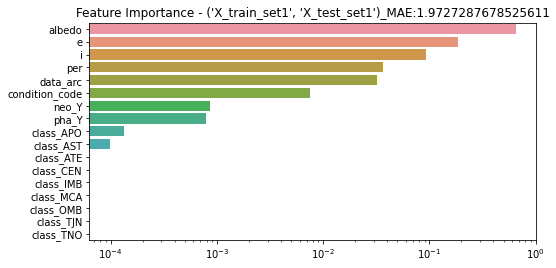

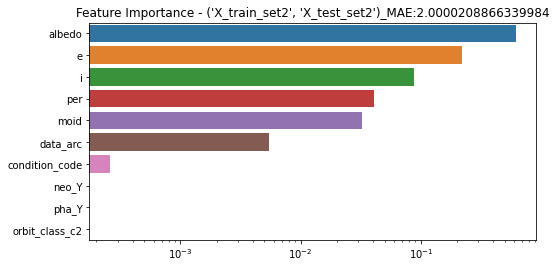

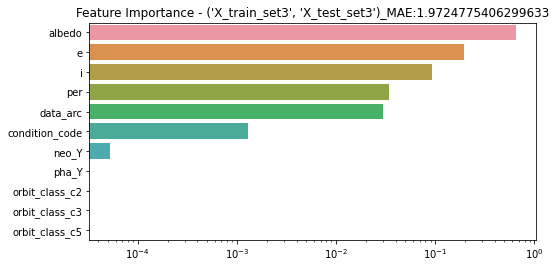

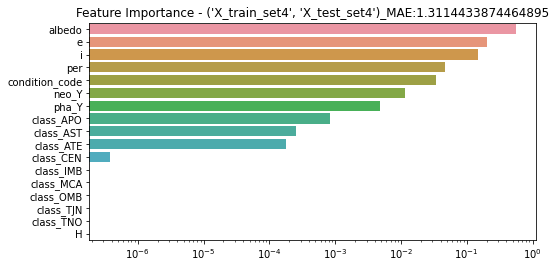

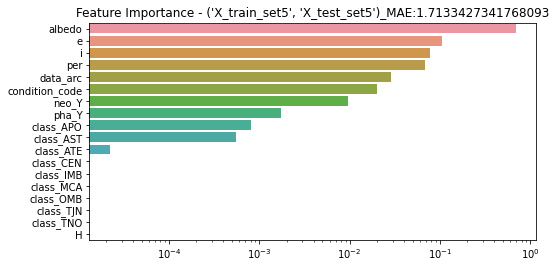

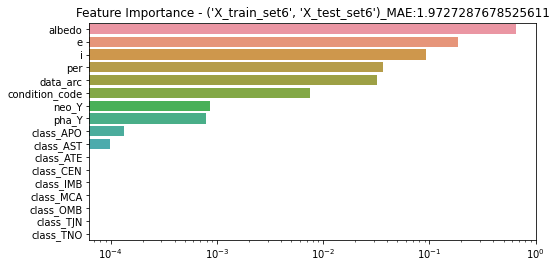

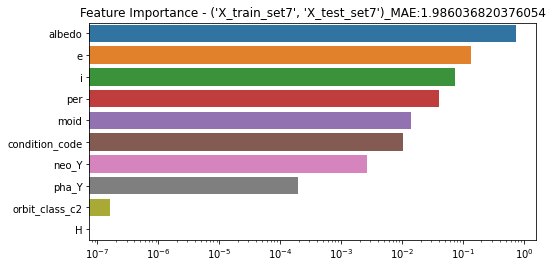

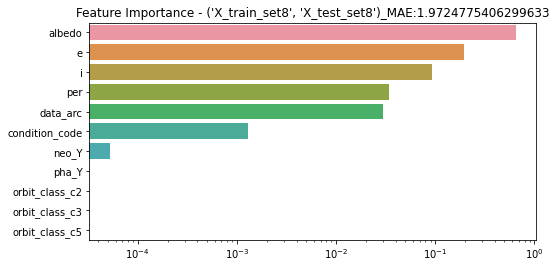

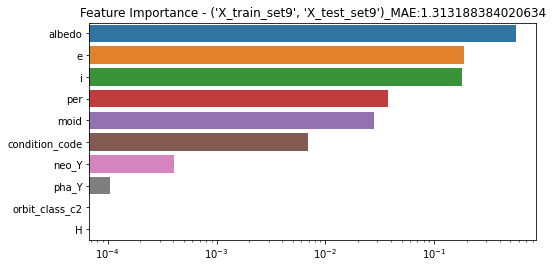

In [ ]:
from sklearn.ensemble import RandomForestRegressor

mae_scores_new_dataset =[]
mae_rf_scores_new_dataset=[]
for dataset in collinearity_removed_dataset:
      train_data = eval(dataset[0])
      test_data = eval(dataset[1])
      lr = LinearRegression()
      rf1 = RandomForestRegressor(n_estimators=100, n_jobs=-1, max_depth=5, random_state=42)
      mae_lr, train_score, test_score= evaluate(train_data, y_train, test_data, y_test, lr, metric)
      mae_rf1, train_score_rf1, test_score_rf1= evaluate(train_data, y_train, test_data, y_test, rf1, metric)
      mae_scores_new_dataset.append(mae_lr)
      mae_rf_scores_new_dataset.append(mae_rf1)

      plot_feature_imp(rf1, train_data, f'{dataset}_MAE:{mae_rf1}')

**Top Important features are albedo, 'e', 'i', per, data_arc, neo_y, pha_y**

## All datasets and Scores

In [ ]:
Datasets_scores['Collinearity_fixed_set'] = collinearity_removed_dataset
Datasets_scores['LR_Mae_cf_set'] = mae_scores_new_dataset
Datasets_scores['RF_Mae_cf_set'] = mae_rf_scores_new_dataset

In [ ]:
pd.set_option('display.max_colwidth', 30)
Datasets_scores

,#,Dataset,LR_MAE_Scores,Train Score,Test Score,RF_MAE_Scores,Collinearity_fixed_set,LR_Mae_cf_set,RF_Mae_cf_set
0,Dataset_1,"(X_train_imp_df,...",2.519004,0.517023,0.451986,0.821233,"(X_train_set1, X...",2.655051,1.972729
1,Dataset_2,(X_train_class_f...,2.582081,0.511893,0.463163,0.820748,"(X_train_set2, X...",2.713920,2.000021
2,Dataset_3,(X_train_class_f...,2.582278,0.513076,0.459607,0.819560,"(X_train_set3, X...",2.662630,1.972478
3,Dataset_4,(X_train_H_featu...,2.243917,0.484253,0.416205,1.212846,"(X_train_set4, X...",1.650721,1.311443
4,Dataset_5,(X_train_H_featu...,1.793382,0.669721,0.635121,1.650528,"(X_train_set5, X...",1.962012,1.713343
5,Dataset_6,(X_train_H_featu...,2.275417,0.519861,0.463102,1.627899,"(X_train_set6, X...",2.655051,1.972729
6,Dataset_7,(X_train_featuri...,1.848656,0.664340,0.637728,1.651855,"(X_train_set7, X...",2.160515,1.986037
7,Dataset_8,(X_train_featuri...,2.321201,0.517947,0.465148,1.625726,"(X_train_set8, X...",2.662630,1.972478
8,Dataset_9,(X_train_featuri...,2.339326,0.477141,0.425648,1.213021,"(X_train_set9, X...",1.832891,1.313188


In [ ]:
save_to_csv(Datasets_scores, 'Datasets_scores')

## Observations:
- Dataset based on OptimalBinning of Abosulte magnitude gave the lowest mean absolute error:
    - (X_train_H_featurized_opt, X_test_H_featurized_opt)
    - (X_train_featurized_3, X_test_featurized_3)	
- Next best Dataset based on MAE scores is (X_train_H_featurized_1, X_test_H_featurized_1), which has absolute magnitude feature discreatized based on target Kmeans binned diameter

- **Note** the sets where the MAE went up after collinearity fix, are the ones from which abosulte magnitude feature got removed, so lets add it back and recalculate


In [ ]:
#loading the dataframes from saved csv
X_train_set1 = pd.read_csv('/content/drive/MyDrive/project_asteroid/data/X_train_set1')
X_test_set1 = pd.read_csv('/content/drive/MyDrive/project_asteroid/data/X_test_set1')
X_train_set2 = pd.read_csv('/content/drive/MyDrive/project_asteroid/data/X_train_set2')
X_test_set2 = pd.read_csv('/content/drive/MyDrive/project_asteroid/data/X_test_set2')
X_train_set3 = pd.read_csv('/content/drive/MyDrive/project_asteroid/data/X_train_set3')
X_test_set3 = pd.read_csv('/content/drive/MyDrive/project_asteroid/data/X_test_set3')
X_train_set4 = pd.read_csv('/content/drive/MyDrive/project_asteroid/data/X_train_set4')
X_test_set4 = pd.read_csv('/content/drive/MyDrive/project_asteroid/data/X_test_set4')
X_train_set5 = pd.read_csv('/content/drive/MyDrive/project_asteroid/data/X_train_set5')
X_test_set5 = pd.read_csv('/content/drive/MyDrive/project_asteroid/data/X_test_set5')
X_train_set6 = pd.read_csv('/content/drive/MyDrive/project_asteroid/data/X_train_set6')
X_test_set6 = pd.read_csv('/content/drive/MyDrive/project_asteroid/data/X_test_set6')
X_train_set7 = pd.read_csv('/content/drive/MyDrive/project_asteroid/data/X_train_set7')
X_test_set7 = pd.read_csv('/content/drive/MyDrive/project_asteroid/data/X_test_set7')
X_train_set8 = pd.read_csv('/content/drive/MyDrive/project_asteroid/data/X_train_set8')
X_test_set8 = pd.read_csv('/content/drive/MyDrive/project_asteroid/data/X_test_set8')
X_train_set9 = pd.read_csv('/content/drive/MyDrive/project_asteroid/data/X_train_set9')
X_test_set9 = pd.read_csv('/content/drive/MyDrive/project_asteroid/data/X_test_set9')

In [ ]:
#lets add 'H' back to set1, 2, 3, 6 and 8
X_train_set1['H'] = X_train_imp_df.H
X_test_set1['H'] = X_test_imp_df.H

X_train_set2['H'] = X_train_imp_df.H
X_test_set2['H'] = X_test_imp_df.H

X_train_set3['H'] = X_train_imp_df.H
X_test_set3['H'] = X_test_imp_df.H

X_train_set6['H'] = X_train_H_featurized_2.H
X_test_set6['H'] = X_test_H_featurized_2.H

X_train_set8['H'] = X_train_H_featurized_2.H
X_test_set8['H'] = X_test_H_featurized_2.H

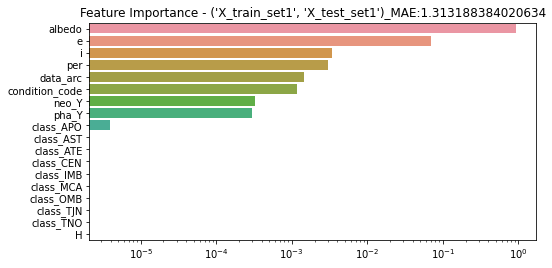

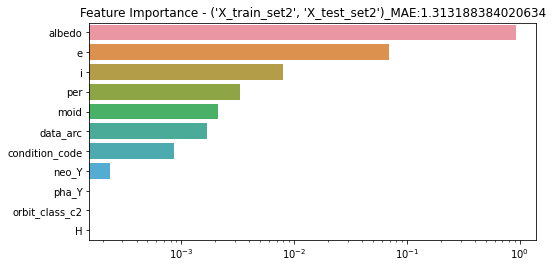

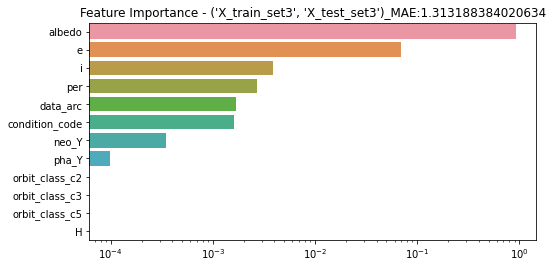

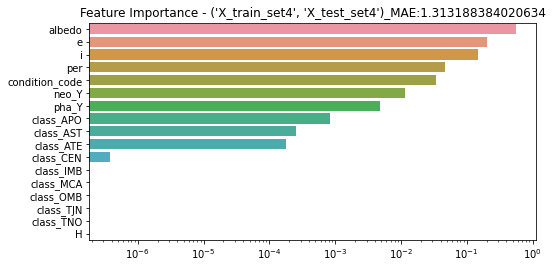

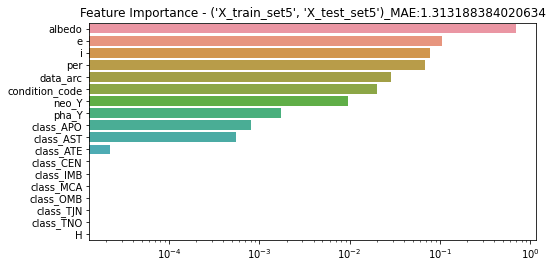

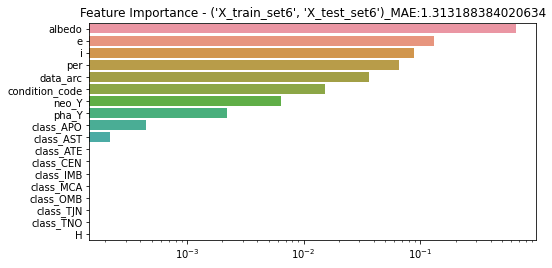

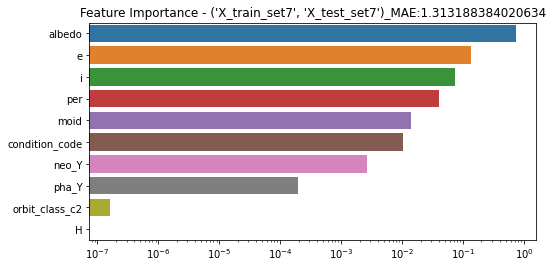

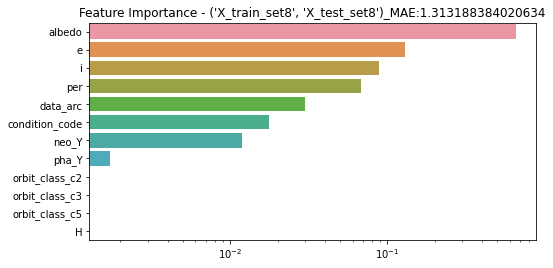

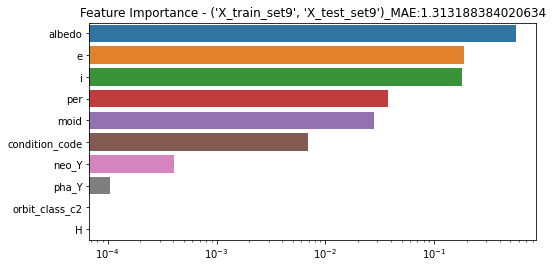

In [ ]:
mae_scores_new_dataset_h =[]
mae_rf_scores_new_dataset_h=[]
lr_scores_new = []
rf_scores_new = []
for dataset in collinearity_removed_dataset:
      train_data = eval(dataset[0])
      test_data = eval(dataset[1])
      lr = LinearRegression()
      rf1 = RandomForestRegressor(n_estimators=100, n_jobs=-1, max_depth=5, random_state=42)
      mae_lr_h, train_score, test_score= evaluate(train_data, y_train, test_data, y_test, lr, metric)
      mae_rf1_h, train_score_rf1, test_score_rf1= evaluate(train_data, y_train, test_data, y_test, rf1, metric)
      mae_scores_new_dataset_h.append(mae_lr_h)
      mae_rf_scores_new_dataset_h.append(mae_rf1_h)
      lr_scores_new.append((train_score, test_score))
      rf_scores_new.append((train_score_rf1, test_score_rf1))

      plot_feature_imp(rf1, train_data, f'{dataset}_MAE:{mae_rf1}')

Observations:
- Although adding 'H' to set 1,2,3,6,9 did improve MAEs, but if we notice the feature 'H' is not being considered as an important feature

In [ ]:
## Scores of the sets after adding absolute magnitude feature
pd.DataFrame({"Datasets":collinearity_removed_dataset, "LR_MAE":mae_scores_new_dataset_h, "RF_MAE":mae_rf_scores_new_dataset_h, "LR_R2_Scores":lr_scores_new, "RF_R2_Scores":rf_scores_new})

,Datasets,LR_MAE,RF_MAE,LR_R2_Scores,RF_R2_Scores
0,"(X_train_set1, X...",2.424977,0.820436,(0.4684000150523...,(0.9725830757364...
1,"(X_train_set2, X...",2.563395,0.817732,(0.4601032015051...,(0.9723217217124...
2,"(X_train_set3, X...",2.454822,0.819718,(0.4274419643656...,(0.9722608562514...
3,"(X_train_set4, X...",1.650721,1.311443,(0.3634417471960...,(0.5249431821119...
4,"(X_train_set5, X...",1.962012,1.713343,(0.6204650050963...,(0.8517100446492...
5,"(X_train_set6, X...",2.348748,1.651627,(0.4675293453946...,(0.8441003489453...
6,"(X_train_set7, X...",2.160515,1.986037,(0.6038333082484...,(0.8084036499243...
7,"(X_train_set8, X...",2.354617,1.653606,(0.4248549326806...,(0.8430869814942...
8,"(X_train_set9, X...",1.832891,1.313188,(0.3475094430264...,(0.5215084999258...


## Observations:
- We do note a slight improvement in LR-MAEs after addition of 'H' feature, and significant improvement in RF-MAEs
- As per linear model, set6 looks the best
- with RandomForest score, set 1, 2, 3 looks the best

In [ ]:
#save files
save_to_csv(X_train_set1, 'X_train_set1')
save_to_csv(X_train_set2, 'X_train_set2')
save_to_csv(X_train_set3, 'X_train_set3')
save_to_csv(X_train_set4, 'X_train_set4')
save_to_csv(X_train_set5, 'X_train_set5')
save_to_csv(X_train_set6, 'X_train_set6')
save_to_csv(X_train_set7, 'X_train_set7')
save_to_csv(X_train_set8, 'X_train_set8')
save_to_csv(X_train_set9, 'X_train_set9')

save_to_csv(X_test_set1, 'X_test_set1')
save_to_csv(X_test_set2, 'X_test_set2')
save_to_csv(X_test_set3, 'X_test_set3')
save_to_csv(X_test_set4, 'X_test_set4')
save_to_csv(X_test_set5, 'X_test_set5')
save_to_csv(X_test_set6, 'X_test_set6')
save_to_csv(X_test_set7, 'X_test_set7')
save_to_csv(X_test_set8, 'X_test_set8')
save_to_csv(X_test_set9, 'X_test_set9')

### Evaluate - considering only top important features

Based on feature Importance graphical view, below is what we call most important features for each set:



```
set1: ['albedo', 'e', 'i', 'per', 'data_arc', 'condition_code', 'neo_Y', 'pha_Y']
set2: ['albedo', 'e', 'i', 'per', 'moid', 'data_arc', 'condition_code', 'neo_Y']
set3: ['albedo', 'e', 'i', 'per', 'data_arc', 'condition_code', 'neo_Y', 'pha_Y']
set4: ['albedo', 'e', 'i', 'per', 'condition_code', 'neo_Y', 'pha_Y', 'class_APO', 'class_AST', 'class_ATE', 'class_CEN', 'class_IMB']
set5: ['albedo', 'e', 'i', 'per', 'data_arc', 'condition_code', 'neo_Y', 'pha_Y', 'class_APO', 'class_AST','class_ATE']
set6: ['albedo', 'e', 'i', 'per', 'data_arc', 'condition_code', 'neo_Y', 'pha_Y', 'class_APO', 'class_AST']
set7: ['albedo', 'e', 'i', 'per', 'moid', 'condition_code', 'neo_Y', 'pha_Y', 'orbit_class_c2]
set8: ['albedo', 'e', 'i', 'per', 'data_arc', 'condition_code', 'neo_Y', 'pha_Y']
set9: ['albedo', 'e', 'i', 'per', 'condition_code', 'neo_Y', 'pha_Y','class_APO', 'class_AST', 'class_ATE', 'class_CEN', 'class_IMB']
```

if we note we have 6 unique sets, so lets create these feature sets and evaluate

In [ ]:
feature_important_train_set1 = X_train_set1[['albedo', 'e', 'i', 'per', 'data_arc', 'condition_code', 'neo_Y', 'pha_Y']]
feature_important_test_set1 = X_test_set1[['albedo', 'e', 'i', 'per', 'data_arc', 'condition_code', 'neo_Y', 'pha_Y']]

In [ ]:
lr= LinearRegression()
rf1 = RandomForestRegressor(n_estimators=100, n_jobs=-1, max_depth=5, random_state=42)
print(evaluate(feature_important_train_set1, y_train, feature_important_test_set1, y_test, lr, metric))
print(evaluate(feature_important_train_set1, y_train, feature_important_test_set1, y_test, rf1, metric))

(2.767421829826543, 0.319479362692358, 0.3447801947642173)
(1.9738053527602248, 0.7118078007045394, 0.6313314833617341)


In [ ]:
feature_important_train_set2 = X_train_set2[['albedo', 'e', 'i', 'per', 'moid', 'data_arc', 'condition_code', 'neo_Y']]
feature_important_test_set2 = X_test_set2[['albedo', 'e', 'i', 'per', 'moid', 'data_arc', 'condition_code', 'neo_Y']]

In [ ]:
lr= LinearRegression()
rf1 = RandomForestRegressor(n_estimators=100, n_jobs=-1, max_depth=5, random_state=42)
print(evaluate(feature_important_train_set2, y_train, feature_important_test_set2, y_test, lr, metric))
print(evaluate(feature_important_train_set2, y_train, feature_important_test_set2, y_test, rf1, metric))

(2.71316619122659, 0.42612066182376185, 0.40495629721809323)
(1.999836874179555, 0.7081655676707488, 0.6446306947052883)


In [ ]:
feature_important_train_set4 = X_train_set4[['albedo', 'e', 'i', 'per', 'condition_code', 'neo_Y', 'pha_Y', 'class_APO', 'class_AST', 'class_ATE', 'class_CEN', 'class_IMB']]
feature_important_test_set4 = X_test_set4[['albedo', 'e', 'i', 'per', 'condition_code', 'neo_Y', 'pha_Y', 'class_APO', 'class_AST', 'class_ATE', 'class_CEN', 'class_IMB']]

In [ ]:
lr= LinearRegression()
rf1 = RandomForestRegressor(n_estimators=100, n_jobs=-1, max_depth=5, random_state=42)
print(evaluate(feature_important_train_set4, y_train, feature_important_test_set4, y_test, lr, metric))
print(evaluate(feature_important_train_set4, y_train, feature_important_test_set4, y_test, rf1, metric))

(2.9738037005873768, 0.03244582615976399, 0.03486274565715086)
(2.6513352984856966, 0.2088216513443797, 0.09700221365648187)


In [ ]:
feature_important_train_set5 = X_train_set5[['albedo', 'e', 'i', 'per', 'data_arc', 'condition_code', 'neo_Y', 'pha_Y', 'class_APO', 'class_AST','class_ATE']]
feature_important_test_set5 = X_test_set5[['albedo', 'e', 'i', 'per', 'data_arc', 'condition_code', 'neo_Y', 'pha_Y', 'class_APO', 'class_AST','class_ATE']]

In [ ]:
lr= LinearRegression()
rf1 = RandomForestRegressor(n_estimators=100, n_jobs=-1, max_depth=5, random_state=42)
print(evaluate(feature_important_train_set5, y_train, feature_important_test_set5, y_test, lr, metric))
print(evaluate(feature_important_train_set5, y_train, feature_important_test_set5, y_test, rf1, metric))

(2.768209995753874, 0.31967309045571324, 0.3449717045688069)
(1.9728482989438603, 0.7117941653907474, 0.6329271866609465)


In [ ]:
feature_important_train_set6 = X_train_set6[['albedo', 'e', 'i', 'per', 'data_arc', 'condition_code', 'neo_Y', 'pha_Y', 'class_APO', 'class_AST']]
feature_important_test_set6 = X_test_set6[['albedo', 'e', 'i', 'per', 'data_arc', 'condition_code', 'neo_Y', 'pha_Y', 'class_APO', 'class_AST']]

In [ ]:
lr= LinearRegression()
rf1 = RandomForestRegressor(n_estimators=100, n_jobs=-1, max_depth=5, random_state=42)
print(evaluate(feature_important_train_set6, y_train, feature_important_test_set6, y_test, lr, metric))
print(evaluate(feature_important_train_set6, y_train, feature_important_test_set6, y_test, rf1, metric))

(2.7678044780015156, 0.3196356352396126, 0.344937238662374)
(1.9734931740069184, 0.7117088332673893, 0.6323732228820786)


In [ ]:
feature_important_train_set7 = X_train_set7[['albedo', 'e', 'i', 'per', 'moid', 'condition_code', 'neo_Y', 'pha_Y', 'orbit_class_c2']]
feature_important_test_set7 = X_test_set7[['albedo', 'e', 'i', 'per', 'moid', 'condition_code', 'neo_Y', 'pha_Y', 'orbit_class_c2']]

In [ ]:
lr= LinearRegression()
rf1 = RandomForestRegressor(n_estimators=100, n_jobs=-1, max_depth=5, random_state=42)
print(evaluate(feature_important_train_set7, y_train, feature_important_test_set7, y_test, lr, metric))
print(evaluate(feature_important_train_set7, y_train, feature_important_test_set7, y_test, rf1, metric))

(2.8433104604024675, 0.1382563779015219, 0.08953046299980383)
(2.648654612254043, 0.2055809808077611, 0.1047139352240326)


- Selecting the important features only, we get our dataset filtered to 6 subsets
- MAE scores and train/test R2 scores degraded considering just the important features

**CONCLUSION** : RandomForest does gave us the most important features which the algo used, but considering only those and modeling did not give improved result. So we would experiment Modeling with the generated master Datasets and the collinearity fixed datasets

## PCA: 2D Data Visualization

Using PCA, we will try here to visualize our datasets and analyze if we can find any pattern in the data

In [ ]:
from sklearn.preprocessing import StandardScaler

# standardizing the numeric columns
def standardize(train_data):
    """ function to standardize train and test data"""
    scaler = StandardScaler()
    num_cols= list(train_data.dtypes[(train_data.dtypes=='float64') | (train_data.dtypes=='int64')].index)
    scaler.fit(train_data.loc[:, num_cols])
    train_data.loc[:, num_cols] = scaler.transform(train_data.loc[:, num_cols])
    return train_data

In [ ]:
# feature extraction using PCA
from sklearn.decomposition import PCA

def pca_cluster(train_set):
      """function computes 2 principal components for the dataset and plots the features"""
      feature_train_set= standardize(train_set)
      pca = PCA(n_components=2)
      pca.fit(feature_train_set)
      X_pca = pca.transform(feature_train_set)

      print(f"% of variance retained: {np.sum(pca.explained_variance_ratio_ )*100}")
      X_pca_df = pd.DataFrame(X_pca, columns=['component1', 'component2'])

      fig, ax = plt.subplots(figsize=(10,4))
      sns.scatterplot(data=X_pca_df, x='component1', y='component2', ax=ax)
      ax.set_title("PCA")
      plt.show()


### PCA: featurized datasets

In [ ]:
datasets

[('X_train_imp_df', 'X_test_imp_df'),
 ('X_train_class_featured1', 'X_test_class_featured1'),
 ('X_train_class_featured2', 'X_test_class_featured2'),
 ('X_train_H_featurized_opt', 'X_test_H_featurized_opt'),
 ('X_train_H_featurized_1', 'X_test_H_featurized_1'),
 ('X_train_H_featurized_2', 'X_test_H_featurized_2'),
 ('X_train_featurized_1', 'X_test_featurized_1'),
 ('X_train_featurized_2', 'X_test_featurized_2'),
 ('X_train_featurized_3', 'X_test_featurized_3')]

% of variance retained: 29.17705921375496


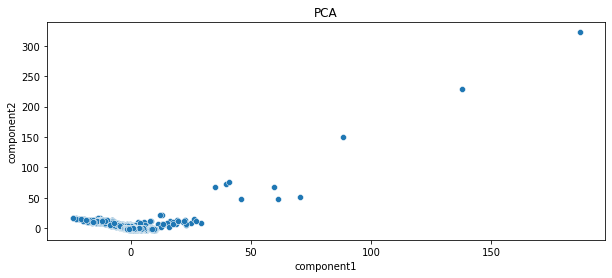

In [ ]:
pca_cluster(X_train_imp_df)

% of variance retained: 37.23243177441206


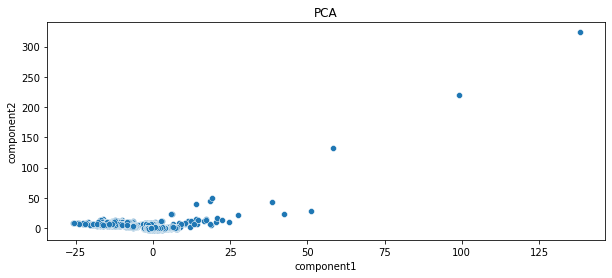

In [ ]:
pca_cluster(X_train_class_featured1)

% of variance retained: 33.634210623025616


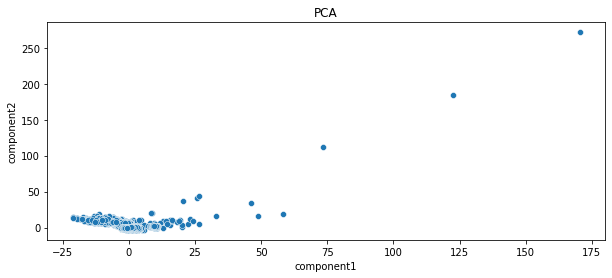

In [ ]:
pca_cluster(X_train_class_featured2)

% of variance retained: 28.857424384604112


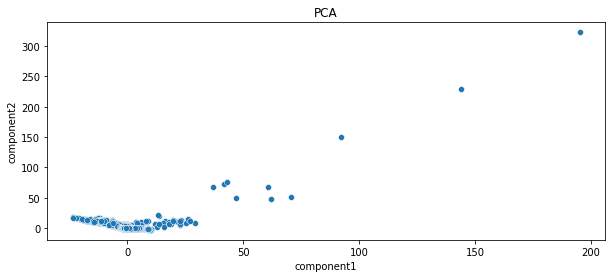

In [ ]:
pca_cluster(X_train_H_featurized_opt)

% of variance retained: 28.633234709651518


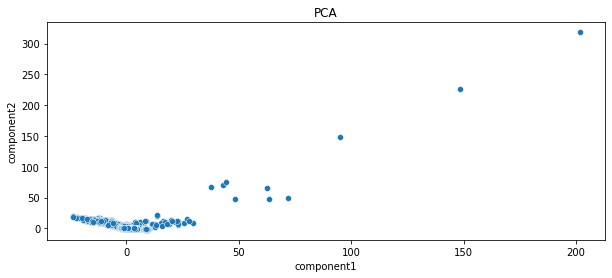

In [ ]:
pca_cluster(X_train_H_featurized_1)

% of variance retained: 29.01003905550523


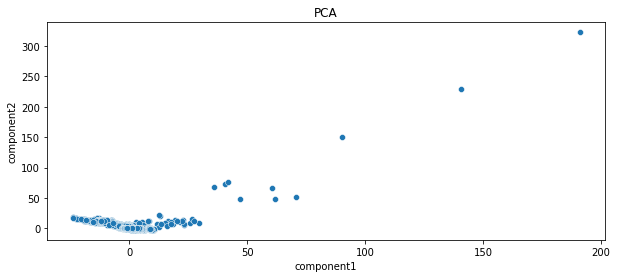

In [ ]:
pca_cluster(X_train_H_featurized_2)

% of variance retained: 36.52261706538867


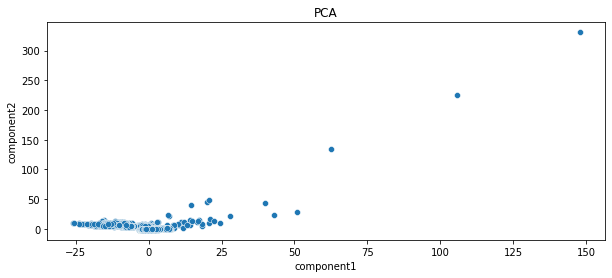

In [ ]:
pca_cluster(X_train_featurized_1)

% of variance retained: 33.4043284316324


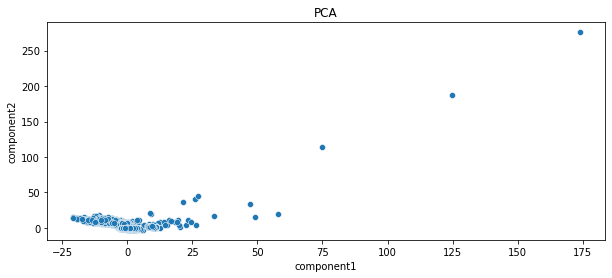

In [ ]:
pca_cluster(X_train_featurized_2)

% of variance retained: 37.23243180993862


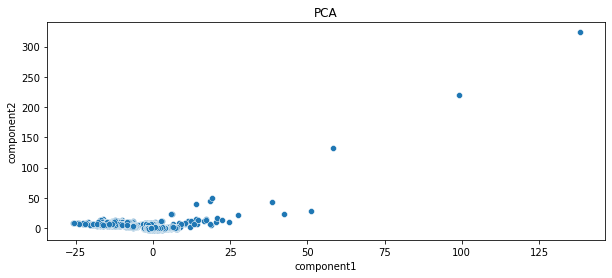

In [ ]:
pca_cluster(X_train_class_featured1)

Observations:

- we did not observe different distinct clusters in any of the sets

### PCA: collinearity fixed datasets

% of variance retained: 25.144992868756866


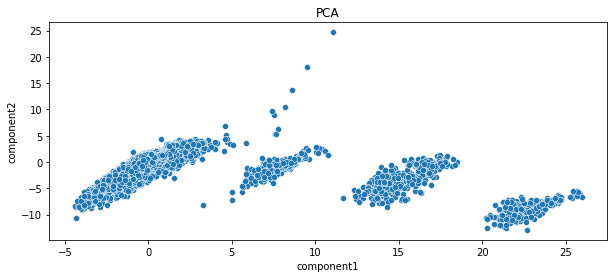

In [ ]:
pca_cluster(X_train_set1)

% of variance retained: 37.74952551504938


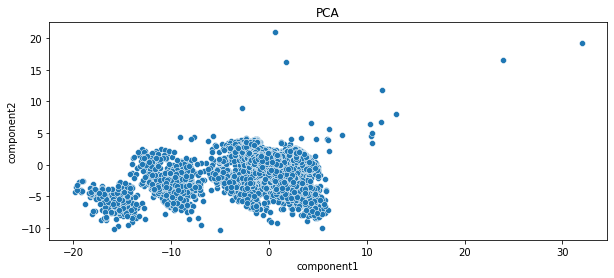

In [ ]:
 pca_cluster(X_train_set2)

% of variance retained: 32.21453398023109


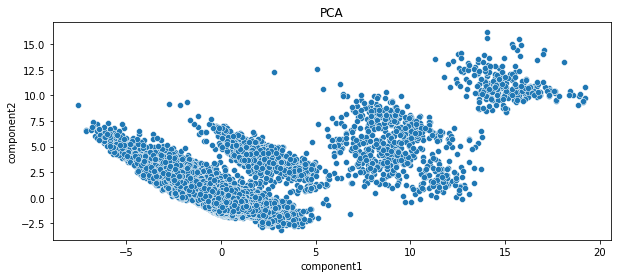

In [ ]:
 pca_cluster(X_train_set3)

% of variance retained: 25.0594184673352


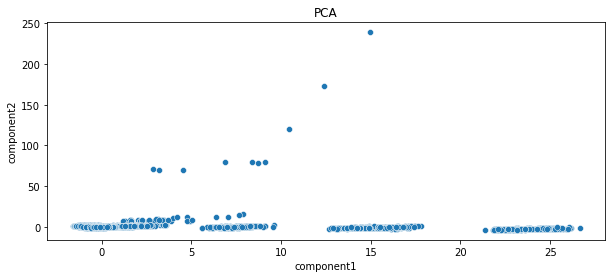

In [ ]:
 pca_cluster(X_train_set4)

% of variance retained: 23.766635123614062


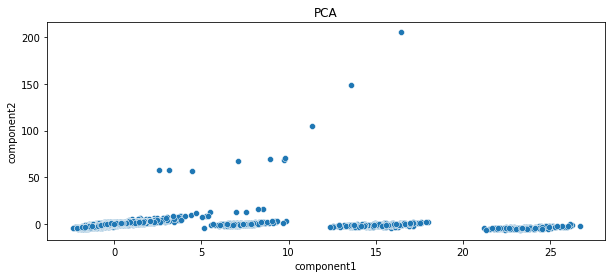

In [ ]:
 pca_cluster(X_train_set5)

% of variance retained: 24.38118155818627


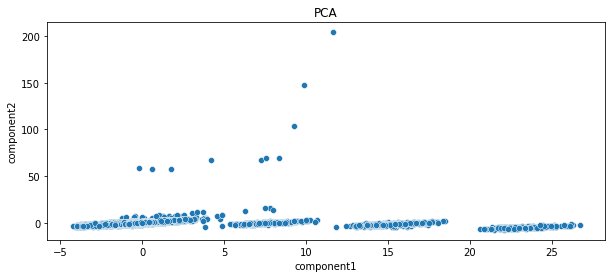

In [ ]:
 pca_cluster(X_train_set6)

% of variance retained: 35.58472360655176


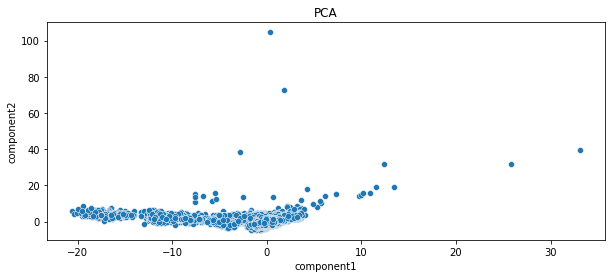

In [ ]:
 pca_cluster(X_train_set7)

% of variance retained: 30.896865458693767


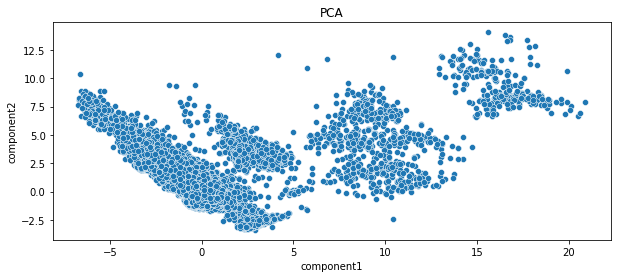

In [ ]:
 pca_cluster(X_train_set8)

% of variance retained: 35.91239741819779


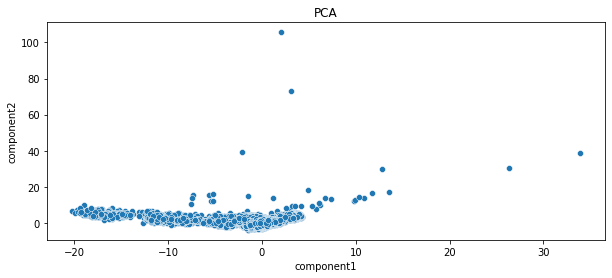

In [ ]:
 pca_cluster(X_train_set9)

Observation: 
Very interesting results
- Except for set7, all the set display distinct 4 clusters
- X_train_set1 clusters look great